In [1]:
%%javascript
<!-- Ignore this block -->
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#  Data preprocessing
1. convert any non-numeric values to numeric values. 
2. If required drop out the rows with missing values or NA. In next lectures we will handle sparse data, which will allow us to use records with missing values.
3. Split the data into a train(80%) and test(20%) .

In [2]:
%config InlineBackend.figure_format = 'retina'

from __future__ import division
import pandas as pd
import numpy as np
from math import sqrt, isnan
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


"""Set global rcParams for pyplotlib"""
plt.rcParams["figure.figsize"] = "18,25"

### TextEncoder

Here the data is mix of numbers and text. Text value cannot be directly used and should be converted to numeric data.<br>
For this I have created a function text encoder which accepts a pandas series. Text encoder returns a lookUp dictionary for recreating the numeric value for text value.

In [3]:
def textEncoder(*textVectors):
    lookUpDictionary = {}
    lookupValue = 1
    for textVector in textVectors:
        for key in textVector.unique():
            if key not in lookUpDictionary:
                lookUpDictionary[key] = lookupValue
                lookupValue +=1
        
    return lookUpDictionary  

### SplitDataSet Procedure
This method splits the dataset into trainset and testset based upon the trainSetSize value. For splitting the dataset, I am using pandas.sample to split the data. This gives me trainset. For testset I am calculating complement of the trainset. This I am doing by droping the index present in training set.

In [4]:
"""Splits the provided pandas dataframe into training and test dataset"""
def splitDataSet(inputDataframe, trainSetSize):
    
        trainSet = inputDataframe.sample(frac=trainSetSize)
        testSet = inputDataframe.drop(trainSet.index)
        return trainSet,testSet

### generatePearsonCoefficient Procedure
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec">
For sample:-
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0">
For selecting some features and for dropping others I am using Pearson's Coefficient. The value of Pearson's coefficient lies between [-1, 1] and tells how two features are related<br>
<table>
<tr><td>Strength of Association</td><td>Positive</td><td>Negative</td></tr><tr><td>Small</td><td>.1 to .3  </td><td>-0.1 to -0.3  </td></tr><tr><td>Medium</td><td>.3 to .5  </td><td>-0.3 to -0.5  </td></tr><tr><td>Large</td><td>.5 to 1.0 </td><td>-0.5 to -1.0  </td></tr></table>


In [5]:
"""Generate pearson's coefficient"""

def generatePearsonCoefficient(A, B):
    A = A - A.mean()
    B = B - B.mean()
    return ((A * B).sum())/(sqrt((A * A).sum()) * sqrt((B * B).sum())) 

### predictLinearRegression Procedure
This method performs predicts the value for Y given X and model parameters. This method will add bias to X.<br>
The prediction is given by BX<sup>T</sup>

In [6]:
"""Method to make prediction for yTest"""
def predictionLinearRegression(X, modelParameters):
    X = np.insert(X, 0, 1, axis=1)
    yPrediction = np.dot(modelParameters, X.T)
    return yPrediction 

### RMSE procedure
Will calculate root mean squared error for given Ytrue values and YPrediction.
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/fc187c3557d633423444d4c80a4a50cd6ecc3dd4">


In [7]:
"""Model accuracy estimator RMSE"""

def RMSE(yTrue, yPrediction):
    n = yTrue.shape[0]
    return sqrt((1.0) * np.sum(np.square((yTrue - yPrediction))))/n

### armijoStepLengthController proedure
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ed6d74a5c23f9034a072125eeb316eee5faeed43">

In [8]:
"""Uses armijo principle to detect next value of alpha.
Alpha values are rewritten. Passed to function just to maintain uniformity

"""

def armijoStepLengthController(fx, alpha, x, y, beta, gradient, delta, maxIterations = 1000):
    
    alpha = 1.0
    gradientSquare = np.dot(gradient, gradient)
    
    for i in range(0, maxIterations):
        
        alpha = alpha/2
    
        residual_alpha_gradient = y - np.dot((beta - (alpha * gradient)), x .T)
        fx_alpha_gradient = np.dot(residual_alpha_gradient.T, residual_alpha_gradient)

        """Convergence condition for armijo principle"""
        if fx_alpha_gradient < fx - (alpha * delta * gradientSquare):
            break;
            
    return alpha

### boldDriverStepLengthController procedure
An extension to armijo steplength controller. Retain alpha values.

In [9]:
def boldDriverStepLengthController(fx, alpha, x, y, beta, gradient, maxIterations = 1000, 
                                   alphaMinus = 0.5, alphaPlus = 1.1):
    alpha = alpha * alphaPlus
    
    for i in range(0, maxIterations):
        
        alpha = alpha * alphaMinus
        residual_alpha_gradient = y - np.dot((beta - (alpha * gradient)), x .T)
        fx_alpha_gradient = np.dot(residual_alpha_gradient.T, residual_alpha_gradient)
        
        """Convergence condition for bold driver method"""
        if fx - fx_alpha_gradient > 0:
            break;
    return alpha

### linearRegressionGradientDescent procedure
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/26a319f33db70a80f8c5373f4348a198a202056c">
Calculate slope at the given point(gradient) and travel in the negative direction with provided step length.<br/>

In [10]:
"""If no step length controller is provided then values of alpha will be taken as step length.
Else the step length controller will be used. Additional parameters to the controller are
provided by stepLengthControllerParameters"""

def linearRegressionGradientDescent(x, y, xTest, yTest, alpha, beta,
                                    maxIterations=1000, epsilon=1.1e-20, 
                                    stepLengthController = None, stepLengthControllerParameters = None):
    x = np.insert(x, 0, 1, axis=1)
    x = x * 1.0
    y = y * 1.0

    if stepLengthController != None:
        print("Warning using stepLengthController alpha values will be rewritten")
            
    plotX = []
    plotY_diff = []
    plotY_RMSE = []
    
    y_prediction = np.dot(beta, x.T)
    residual = y_prediction - y
    f_x = np.dot(residual.T, residual)
    
    rmse = RMSE(yTest, predictionLinearRegression(xTest, beta))
    
    """For plotting graph"""
    plotY_RMSE.append(rmse)
    plotY_diff.append(f_x)
    plotX.append(0)
        
    for i in range(1, maxIterations):

        gradient = np.dot(x.T, residual) * 2
        
        """Use step length controller if required"""
        if stepLengthController != None:
            alpha = stepLengthController(fx = f_x, alpha = alpha, x = x, y = y, 
                                         beta = beta, gradient = gradient, **stepLengthControllerParameters)

        beta = beta - (alpha * gradient)

        y_prediction = np.dot(beta, x.T)
        residual = y_prediction - y
        
        f_x_new = np.dot(residual.T, residual)
        rmse = RMSE(yTest, predictionLinearRegression(xTest, beta))
        
        """For plotting graph"""
        plotY_RMSE.append(rmse)
        plotY_diff.append(abs(f_x_new - f_x))
        plotX.append(i)
        
        if abs(f_x - f_x_new) < epsilon:
            print("Converged in " + str(i) + " iterations")
            return beta, plotX, plotY_diff, plotY_RMSE, f_x, rmse
        f_x = f_x_new
        
    print("Warning algorithm failed to converge in " + str(maxIterations) + " interations")
    return beta, plotX, plotY_diff, plotY_RMSE, f_x, rmse

# Gradient descent for airlines fare data

### Load the airlines dataset

In [11]:
""" File path change accordingly"""
directoryPath = "data"


airFareData = pd.read_csv(directoryPath+"/airq402.dat", sep='\s+',header = None)
airFareData.head(10)

"""Adding header"""
airFareData.columns = ["city1", "city2", "avgFare", "distance", "avgWeeklyPassengers",
                       "marketLeadingAirline", "marketShareLA", "averageFare", "lowPriceAirline",
                       "marketShareLPA", "price"]

airFareData.head()

,city1,city2,avgFare,distance,avgWeeklyPassengers,marketLeadingAirline,marketShareLA,averageFare,lowPriceAirline,marketShareLPA,price
0,CAK,ATL,114.47,528,424.56,FL,70.19,111.03,FL,70.19,111.03
1,CAK,MCO,122.47,860,276.84,FL,75.10,123.09,DL,17.23,118.94
2,ALB,ATL,214.42,852,215.76,DL,78.89,223.98,CO,2.77,167.12
3,ALB,BWI,69.40,288,606.84,WN,96.97,68.86,WN,96.97,68.86
4,ALB,ORD,158.13,723,313.04,UA,39.79,161.36,WN,15.34,145.42


### Using textEncoder to convert text data to numeric data

In [12]:
"""Using lambda functions to replace text values based upon lockup dictionary"""

cityLookupDictionary = textEncoder(airFareData.city1, airFareData.city2)
airFareData['city1'] = airFareData.city1.apply(lambda cityName: 
                                               cityLookupDictionary[cityName])
airFareData['city2'] = airFareData.city2.apply(lambda cityName: 
                                               cityLookupDictionary[cityName])

airLineLookupDictionary = textEncoder(airFareData.lowPriceAirline, airFareData.marketLeadingAirline)
airFareData['lowPriceAirline'] = airFareData.lowPriceAirline.apply(lambda cityName: 
                                                                   airLineLookupDictionary[cityName])
airFareData['marketLeadingAirline'] = airFareData.marketLeadingAirline.apply(lambda cityName: 
                                                                             airLineLookupDictionary[cityName])

### Check and remove missing data

In [13]:
airFareData.dropna(inplace = True)
airFareData.head()

,city1,city2,avgFare,distance,avgWeeklyPassengers,marketLeadingAirline,marketShareLA,averageFare,lowPriceAirline,marketShareLPA,price
0,1,5,114.47,528,424.56,1,70.19,111.03,1,70.19,111.03
1,1,69,122.47,860,276.84,1,75.10,123.09,2,17.23,118.94
2,2,5,214.42,852,215.76,2,78.89,223.98,3,2.77,167.12
3,2,8,69.40,288,606.84,4,96.97,68.86,4,96.97,68.86
4,2,17,158.13,723,313.04,11,39.79,161.36,4,15.34,145.42


### Check for corelation between different X and Y

In [14]:
for column in airFareData:
    if column != "price":
        print("The corelation between " + column +" vs price is " + 
              str(generatePearsonCoefficient(airFareData[column], airFareData['price'])))

The corelation between city1 vs price is -0.0212306632917
The corelation between city2 vs price is 0.0262635217488
The corelation between avgFare vs price is 0.866410337491
The corelation between distance vs price is 0.583239107511
The corelation between avgWeeklyPassengers vs price is -0.142313548005
The corelation between marketLeadingAirline vs price is 0.0653025786559
The corelation between marketShareLA vs price is -0.307671628371
The corelation between averageFare vs price is 0.826510597522
The corelation between lowPriceAirline vs price is 0.062089327918
The corelation between marketShareLPA vs price is -0.240185957175


### Visualizing the data

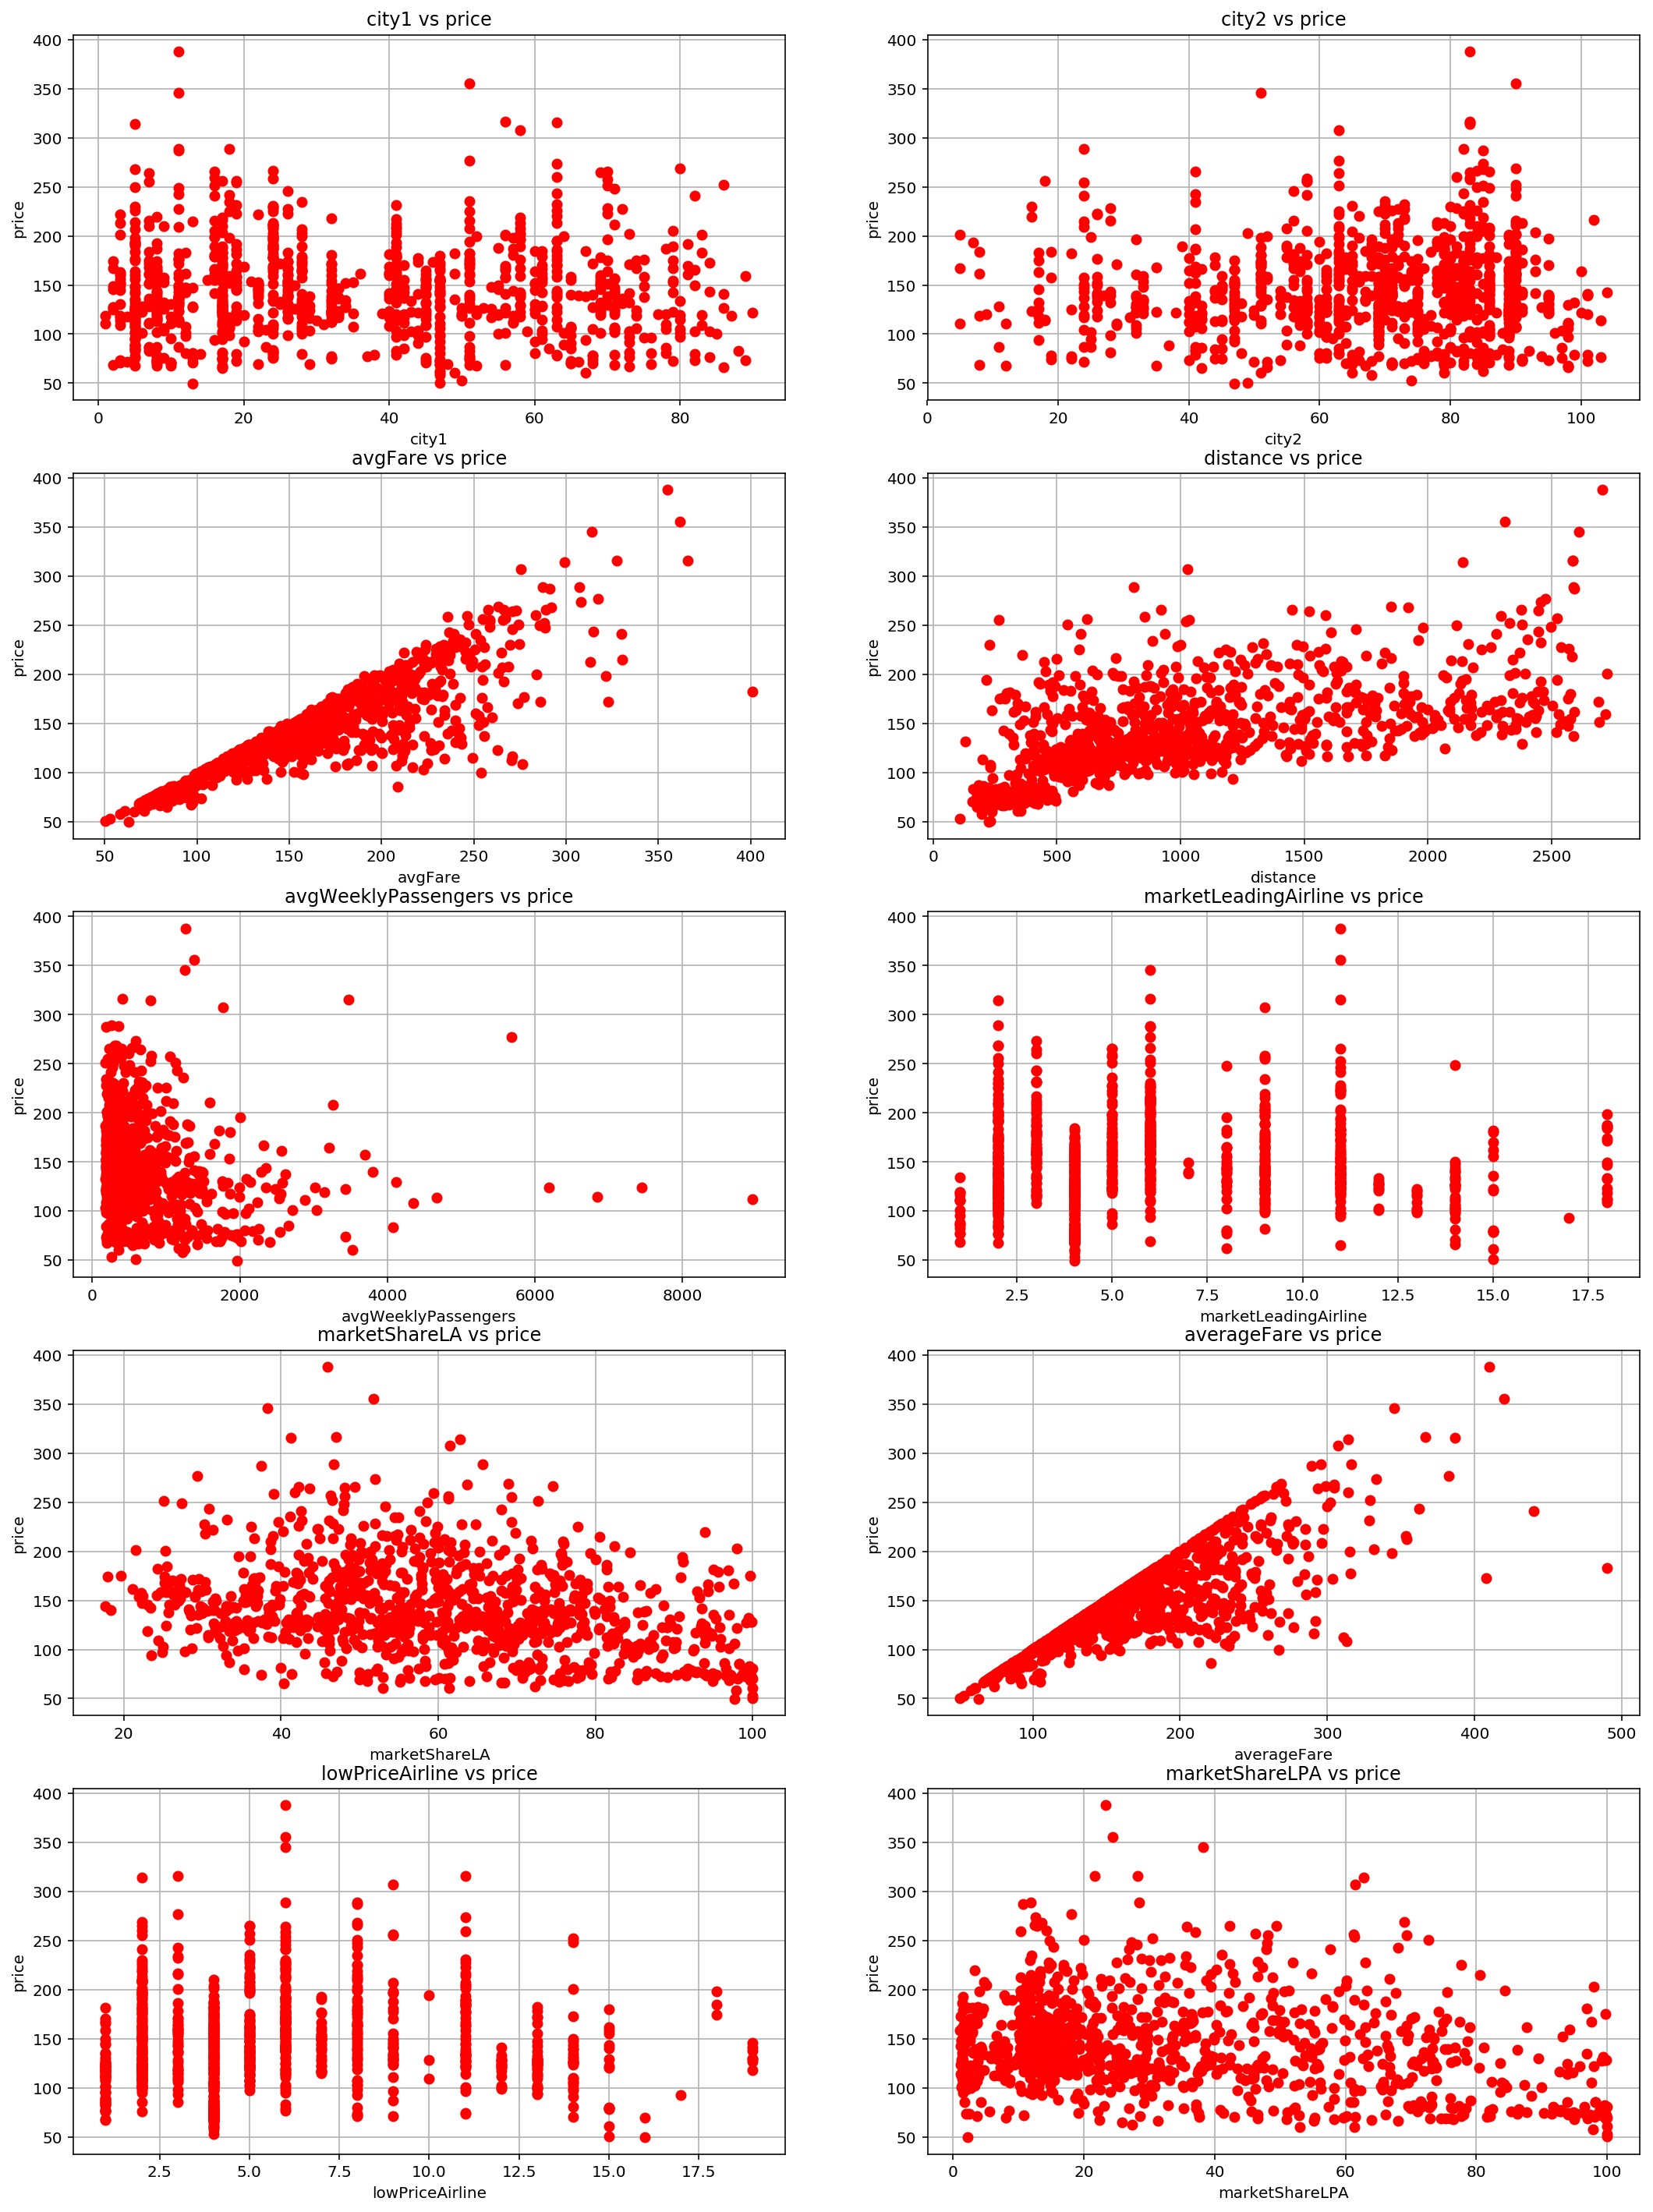

In [15]:
plt.close()
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10))  = plt.subplots(5,2,sharey='none')

ax1.plot(airFareData.city1, airFareData.price, "ro")
ax1.grid()
ax1.set_title("city1 vs price")
ax1.set_xlabel("city1")
ax1.set_ylabel("price")

ax2.plot(airFareData.city2, airFareData.price, "ro")
ax2.grid()
ax2.set_title("city2 vs price")
ax2.set_xlabel("city2")
ax2.set_ylabel("price")

ax3.plot(airFareData.avgFare, airFareData.price, "ro")
ax3.grid()
ax3.set_title("avgFare vs price")
ax3.set_xlabel("avgFare")
ax3.set_ylabel("price")

ax4.plot(airFareData.distance, airFareData.price, "ro")
ax4.grid()
ax4.set_title("distance vs price")
ax4.set_xlabel("distance")
ax4.set_ylabel("price")

ax5.plot(airFareData.avgWeeklyPassengers, airFareData.price, "ro")
ax5.grid()
ax5.set_title("avgWeeklyPassengers vs price")
ax5.set_xlabel("avgWeeklyPassengers")
ax5.set_ylabel("price")

ax6.plot(airFareData.marketLeadingAirline, airFareData.price, "ro")
ax6.grid()
ax6.set_title("marketLeadingAirline vs price")
ax6.set_xlabel("marketLeadingAirline")
ax6.set_ylabel("price")

ax7.plot(airFareData.marketShareLA, airFareData.price, "ro")
ax7.grid()
ax7.set_title("marketShareLA vs price")
ax7.set_xlabel("marketShareLA")
ax7.set_ylabel("price")

ax8.plot(airFareData.averageFare, airFareData.price, "ro")
ax8.grid()
ax8.set_title("averageFare vs price")
ax8.set_xlabel("averageFare")
ax8.set_ylabel("price")

ax9.plot(airFareData.lowPriceAirline, airFareData.price, "ro")
ax9.grid()
ax9.set_title("lowPriceAirline vs price")
ax9.set_xlabel("lowPriceAirline")
ax9.set_ylabel("price")

ax10.plot(airFareData.marketShareLPA, airFareData.price, "ro")
ax10.grid()
ax10.set_title("marketShareLPA vs price")
ax10.set_xlabel("marketShareLPA")
ax10.set_ylabel("price")

plt.show()


By looking at pearson's coefficient we can drop city1, city2, marketLeadingAirline, lowPriceAirline as they do not have any corelation with price.

### Selecting the required features and splitting the dataset using splitDataSetProcedure

In [16]:
airFareData = airFareData[['avgFare', 'distance', 'avgWeeklyPassengers', 'marketShareLA',
                           'averageFare', 'marketShareLPA', 'price']]

airFareData.head()

,avgFare,distance,avgWeeklyPassengers,marketShareLA,averageFare,marketShareLPA,price
0,114.47,528,424.56,70.19,111.03,70.19,111.03
1,122.47,860,276.84,75.10,123.09,17.23,118.94
2,214.42,852,215.76,78.89,223.98,2.77,167.12
3,69.40,288,606.84,96.97,68.86,96.97,68.86
4,158.13,723,313.04,39.79,161.36,15.34,145.42


In [17]:
trainSet, testSet = splitDataSet(airFareData, 0.8)

print(trainSet.shape)
print(testSet.shape)

(800, 7)
(200, 7)


In [18]:
trainSet.head()

,avgFare,distance,avgWeeklyPassengers,marketShareLA,averageFare,marketShareLPA,price
163,125.09,842,1071.63,55.01,128.39,27.15,115.16
128,198.83,408,470.10,72.25,219.61,19.32,139.29
155,167.57,2395,307.82,31.60,174.59,14.12,151.84
224,173.89,2217,207.71,25.64,185.94,17.68,161.48
195,167.56,1256,265.43,35.70,175.92,10.27,149.18


### Running gradient descent with alpha parameter grid serach

Warning algorithm failed to converge in 1000 interations
RMSE nan
Warning algorithm failed to converge in 1000 interations
RMSE nan
Warning algorithm failed to converge in 1000 interations
RMSE 1.66164242754


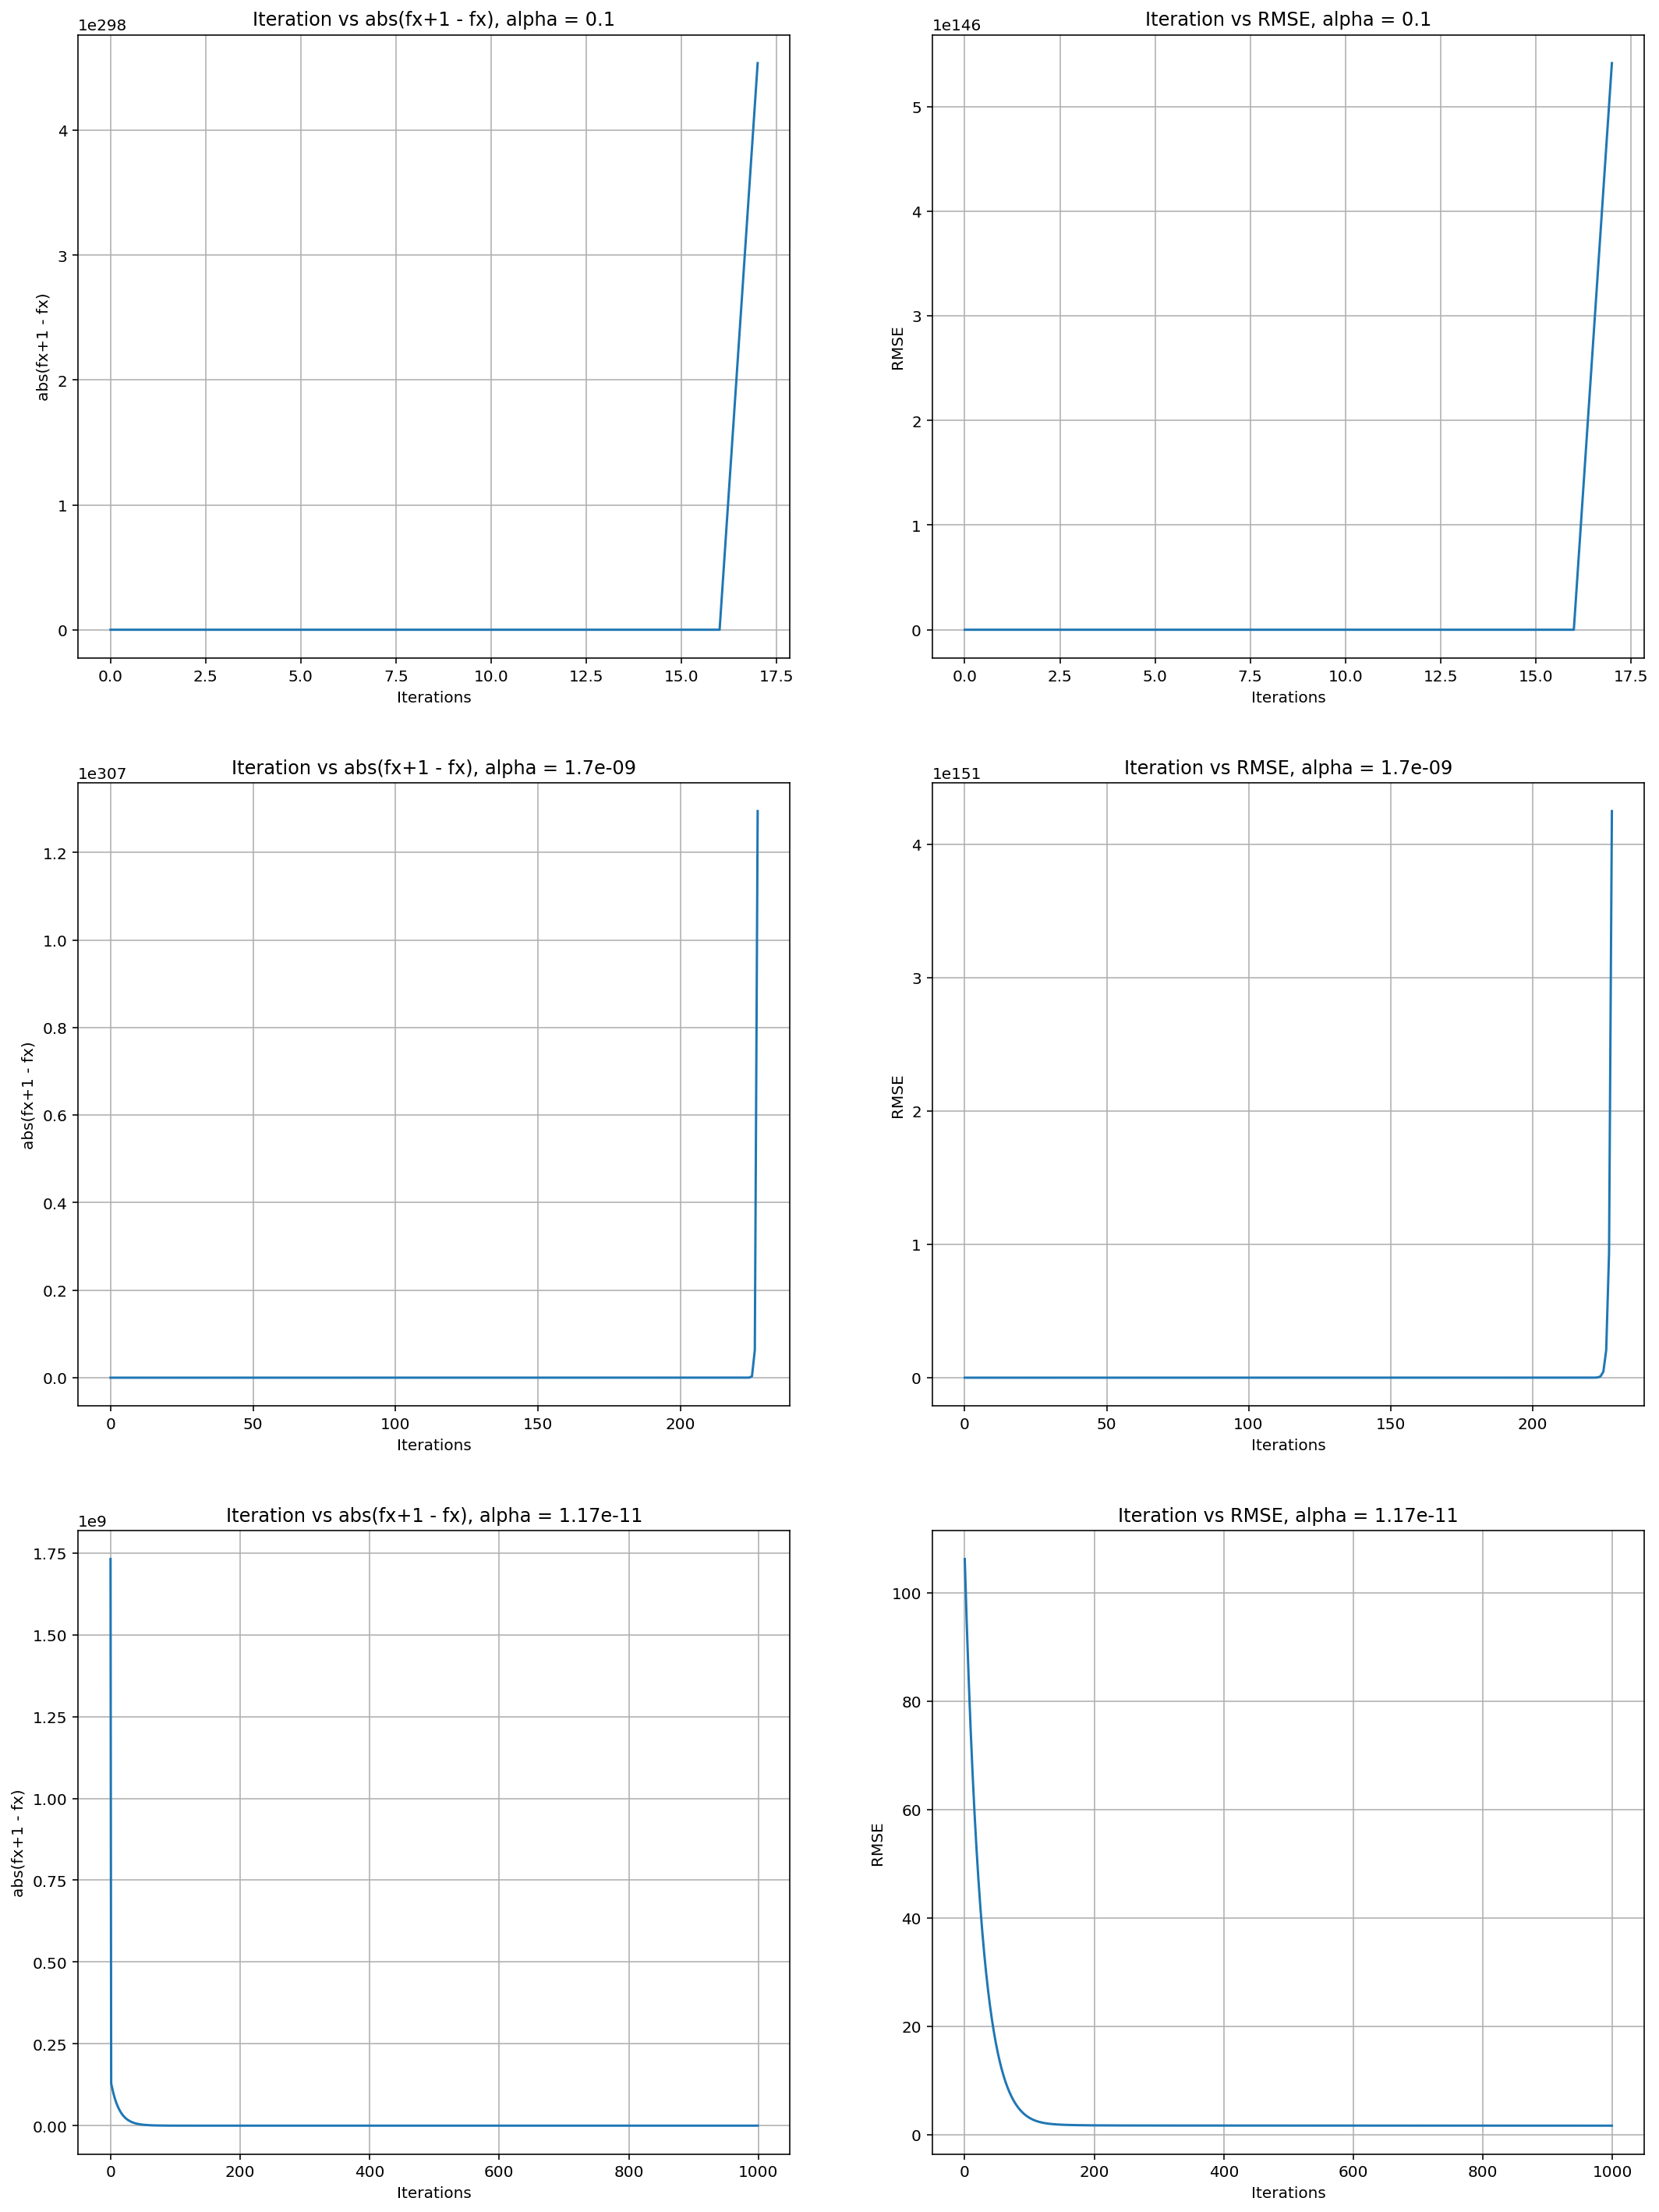

In [19]:
"""Setting beta constant as future comparasion will be easy"""

np.random.seed(8)
inputBeta = np.random.random_sample(7)

alpha_parameterGrid = [0.1, 1.7e-9, 1.17e-11]

X_train = trainSet.as_matrix(columns = ['avgFare', 'distance', 'avgWeeklyPassengers', 'marketShareLA',
                                        'averageFare', 'marketShareLPA'])
X_test = testSet.as_matrix(columns = ['avgFare', 'distance', 'avgWeeklyPassengers', 'marketShareLA',
                                        'averageFare', 'marketShareLPA'])


Y_train = trainSet['price']
Y_test = testSet['price']

figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,sharey='none')
axis = ((ax1, ax2), (ax3, ax4), (ax5, ax6))
index = 0

bestModelParameters = None
bestModelX = None
bestModelY = None
leastRMSE = None
leastRSS = None
for alpha in alpha_parameterGrid:
    
    """No step length controller provided so normal gradient descent will be executed"""
    modelParameters, X, Ydiff, Yrmse, rss, rmse = linearRegressionGradientDescent(X_train, Y_train, X_test, Y_test,
                                                                           alpha, inputBeta,
                                                                           maxIterations = 1000)
    """Selecting the best model with least RMSE"""
    if not(isnan(rmse)):
        if leastRMSE is None or leastRMSE > rmse:
            leastRMSE = rmse
            bestModelParameters = modelParameters
            leastRSS = rss
            bestModelX = X
            bestModelY = Yrmse
            
    print("RMSE "+ str(rmse))
    
    axis[index][0].plot(X, Ydiff)
    axis[index][0].grid()
    axis[index][0].set_title("Iteration vs abs(fx+1 - fx), alpha = " + str(alpha))
    axis[index][0].set_xlabel("Iterations")
    axis[index][0].set_ylabel("abs(fx+1 - fx)")
    
    axis[index][1].plot(X, Yrmse)
    axis[index][1].grid()
    axis[index][1].set_title("Iteration vs RMSE, alpha = " + str(alpha))
    axis[index][1].set_xlabel("Iterations")
    axis[index][1].set_ylabel("RMSE")
    
    index = index + 1
    
plt.show()
plt.close()

### Graph description
<ul><li><b>Alpha = 0.1</b>
<br>Here the alpha value is very big. Because of this instead of converging we are diverging away. Both abs(fx+1 - fx) and RMSE appear to be diverging.
</li><li><b>Alpha = 1.7e-9</b><br>Here also the alpha value is too big. The observed effect is still the same</li><li><b>Alpha = 1.17e-11</b><br>Now alpha value is small enough for algorithm to converge. RMSE is also converging</li>

### Best model

In [20]:
print("Best rmse for alpha grid is "+ str(leastRMSE))
print("Best rss for alpha grid is "+ str(leastRSS))

Best rmse for alpha grid is 1.66164242754
Best rss for alpha grid is 446148.446711


### Some sample predictions

In [21]:
yPrediction = predictionLinearRegression(X_test,bestModelParameters)
df = pd.DataFrame({"Actual":Y_test, "Prediction":yPrediction})
df.head(25)

,Actual,Prediction
5,127.69,119.309814
19,222.08,192.914401
44,122.01,116.051308
48,111.97,172.289487
49,118.58,110.976742
52,94.72,100.278509
59,125.63,113.738888
71,114.65,102.851857
74,148.69,208.577444
81,128.00,188.147552


### Armijo Step Length Controller

Warning using stepLengthController alpha values will be rewritten
Warning algorithm failed to converge in 1000 interations
RMSE 1.52011921126


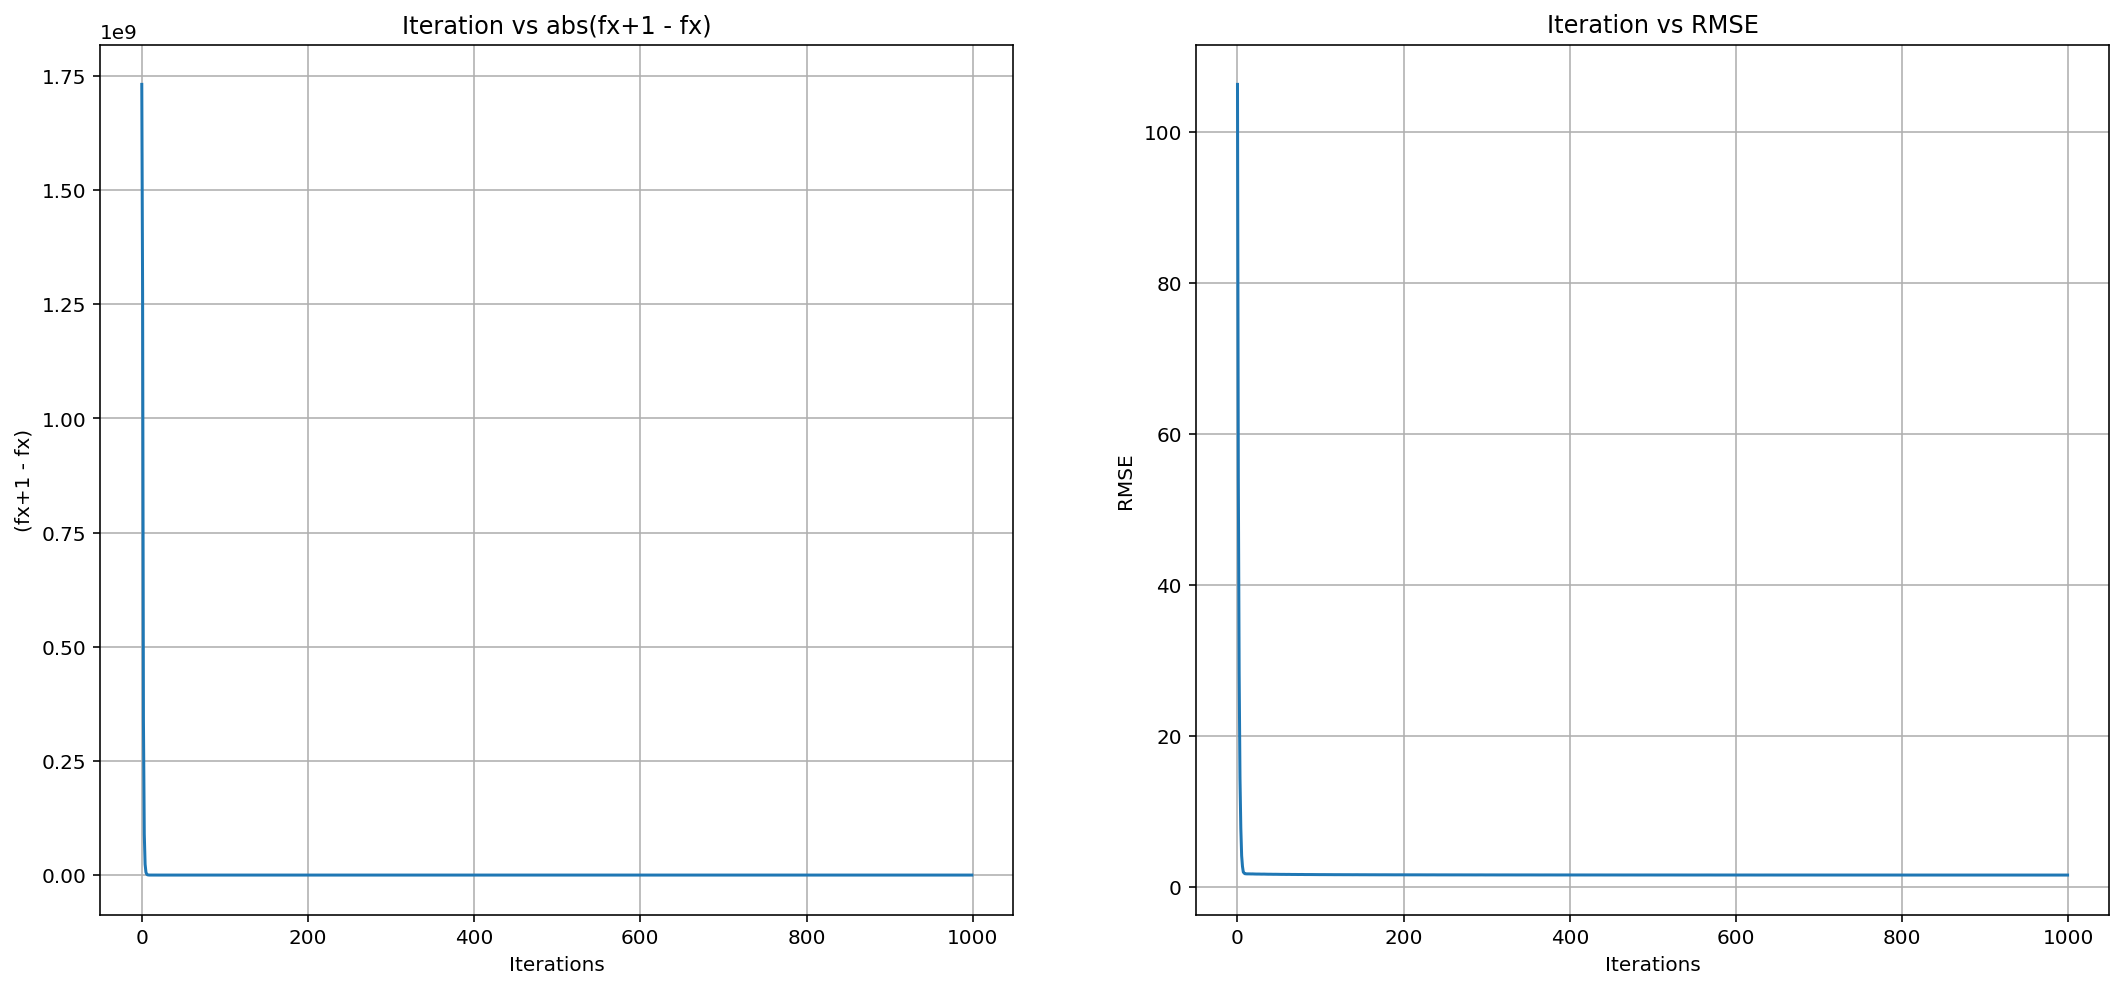

In [22]:
plt.close()
figure, ((ax1, ax2)) = plt.subplots(1, 2, sharey='none')

"""Set steplengthController to armijoStepLengthController and 
stepLengthControllerParameters as any additional model parameters"""

modelParameters, xArmijo, ydiffArmijo, yRMSEArmijo, rss, rmse = linearRegressionGradientDescent(X_train, Y_train, 
                                            X_test, Y_test,
                                            None, inputBeta, maxIterations = 1000,
                                            stepLengthController = armijoStepLengthController,
                                            stepLengthControllerParameters = {"delta":0.2})                    
                                            
                                                                        
figure.set_figheight(8)
print("RMSE "+ str(rmse))
ax1.plot(xArmijo, ydiffArmijo)
ax1.grid()
ax1.set_title("Iteration vs abs(fx+1 - fx)")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("(fx+1 - fx)")

ax2.plot(xArmijo, yRMSEArmijo)
ax2.grid()
ax2.set_title("Iteration vs RMSE")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("RMSE")
plt.show()


### Some sample predictions

In [23]:
yPrediction = predictionLinearRegression(X_test,modelParameters)
df = pd.DataFrame({"Actual":Y_test, "Prediction":yPrediction})
df.head(25)

,Actual,Prediction
5,127.69,119.092210
19,222.08,199.458988
44,122.01,111.510204
48,111.97,165.866702
49,118.58,111.157702
52,94.72,93.739416
59,125.63,115.450873
71,114.65,104.880697
74,148.69,211.535030
81,128.00,187.573010


### Bold Driver Step Length Controller

Warning using stepLengthController alpha values will be rewritten
Warning algorithm failed to converge in 1000 interations
RMSE 1.5209469885


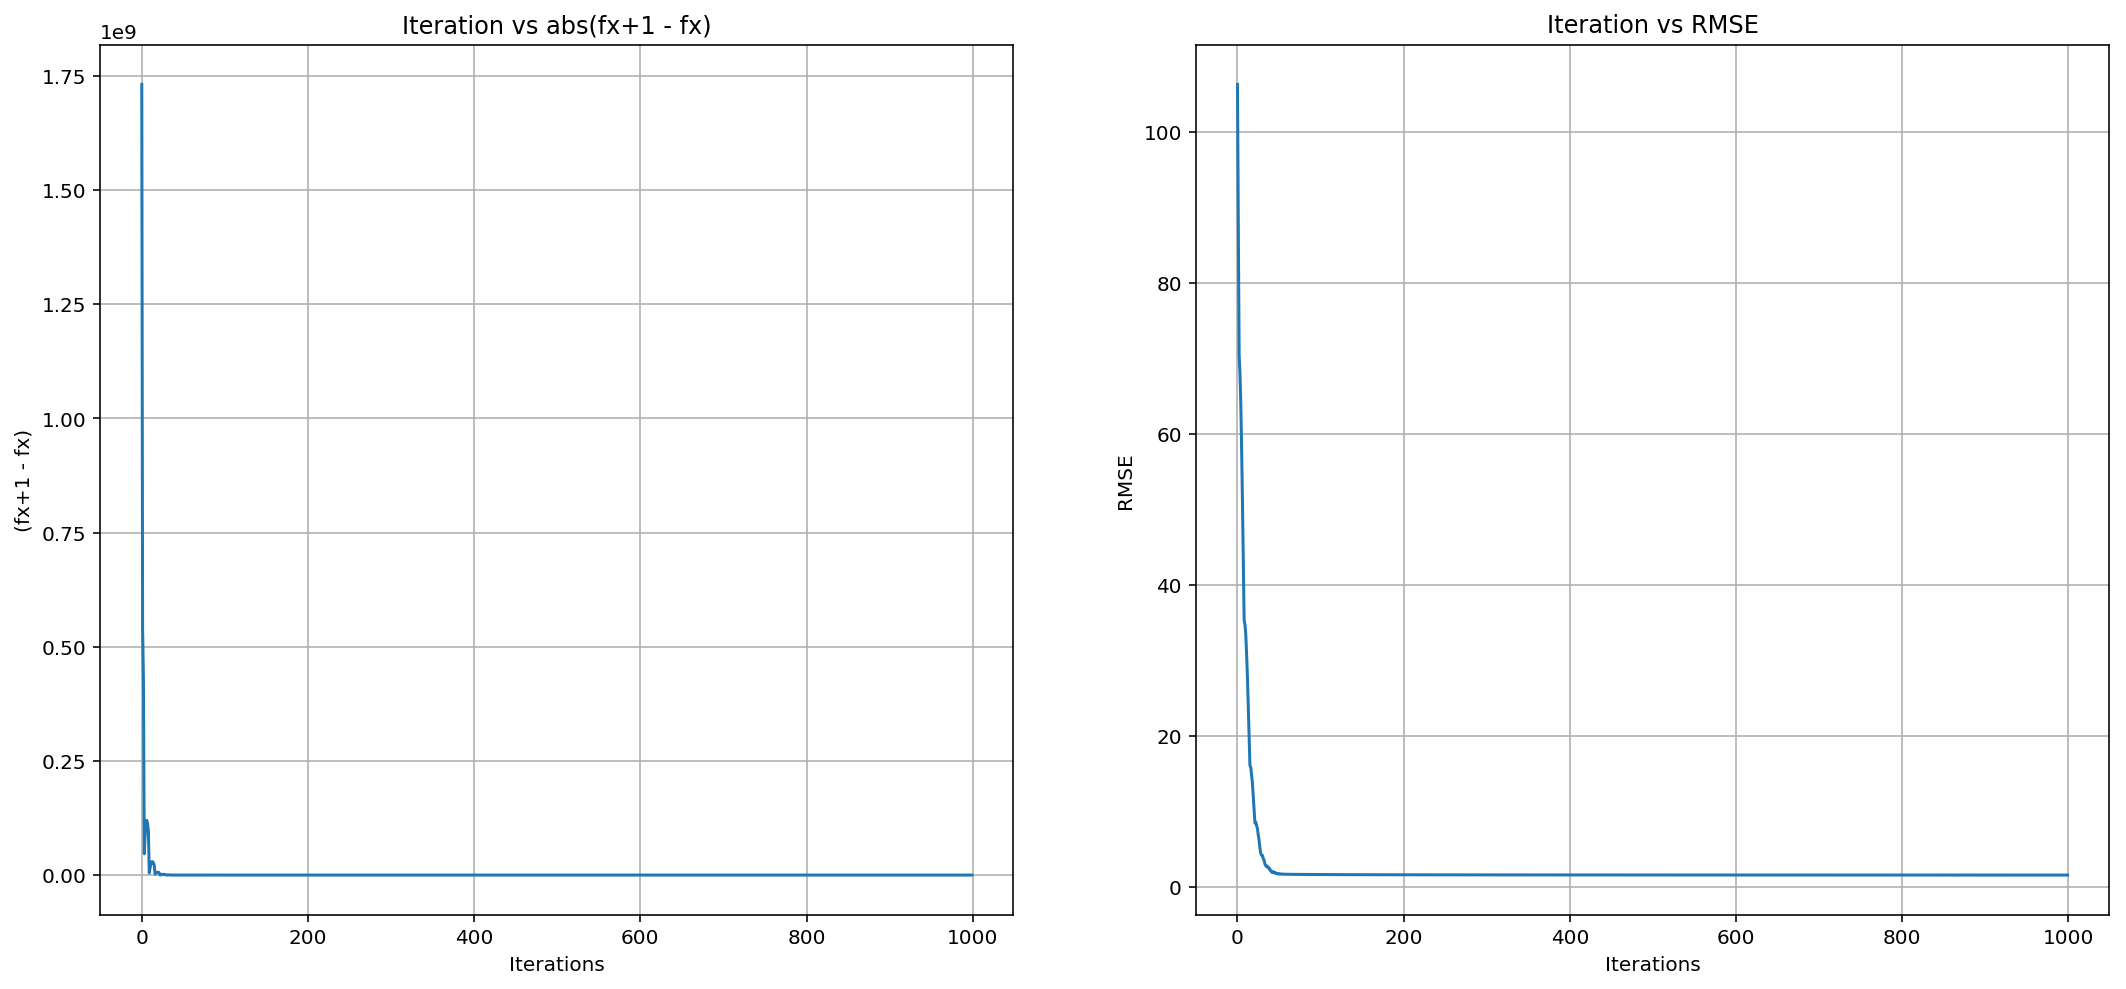

In [24]:
figure, ((ax1, ax2)) = plt.subplots(1, 2, sharey='none')

"""Set steplengthController to boldDriverStepLengthController and 
stepLengthControllerParameters as any additional model parameters"""

modelParameters, xBold, yDiffBold, yRMSEBold, rss, rmse = linearRegressionGradientDescent(X_train, Y_train, 
                                                        X_test, Y_test,
                                                        1.0, inputBeta, maxIterations = 1000,
                                                        stepLengthController = boldDriverStepLengthController,
                                                        stepLengthControllerParameters = 
                                                        {"alphaMinus" : 0.9, "alphaPlus" : 1.5})
figure.set_figheight(8)
print("RMSE "+ str(rmse))
ax1.plot(xBold, yDiffBold)
ax1.grid()
ax1.set_title("Iteration vs abs(fx+1 - fx)")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("(fx+1 - fx)")

ax2.plot(xBold, yRMSEBold)
ax2.grid()
ax2.set_title("Iteration vs RMSE")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("RMSE")

plt.show()

### Sample predictions

In [25]:
yPrediction = predictionLinearRegression(X_test,modelParameters)
df = pd.DataFrame({"Actual":Y_test, "Prediction":yPrediction})
df.head(25)

,Actual,Prediction
5,127.69,119.013405
19,222.08,198.613874
44,122.01,111.510230
48,111.97,165.717139
49,118.58,110.882591
52,94.72,94.118195
59,125.63,115.129467
71,114.65,104.534914
74,148.69,211.215601
81,128.00,187.214820


### Comparasion

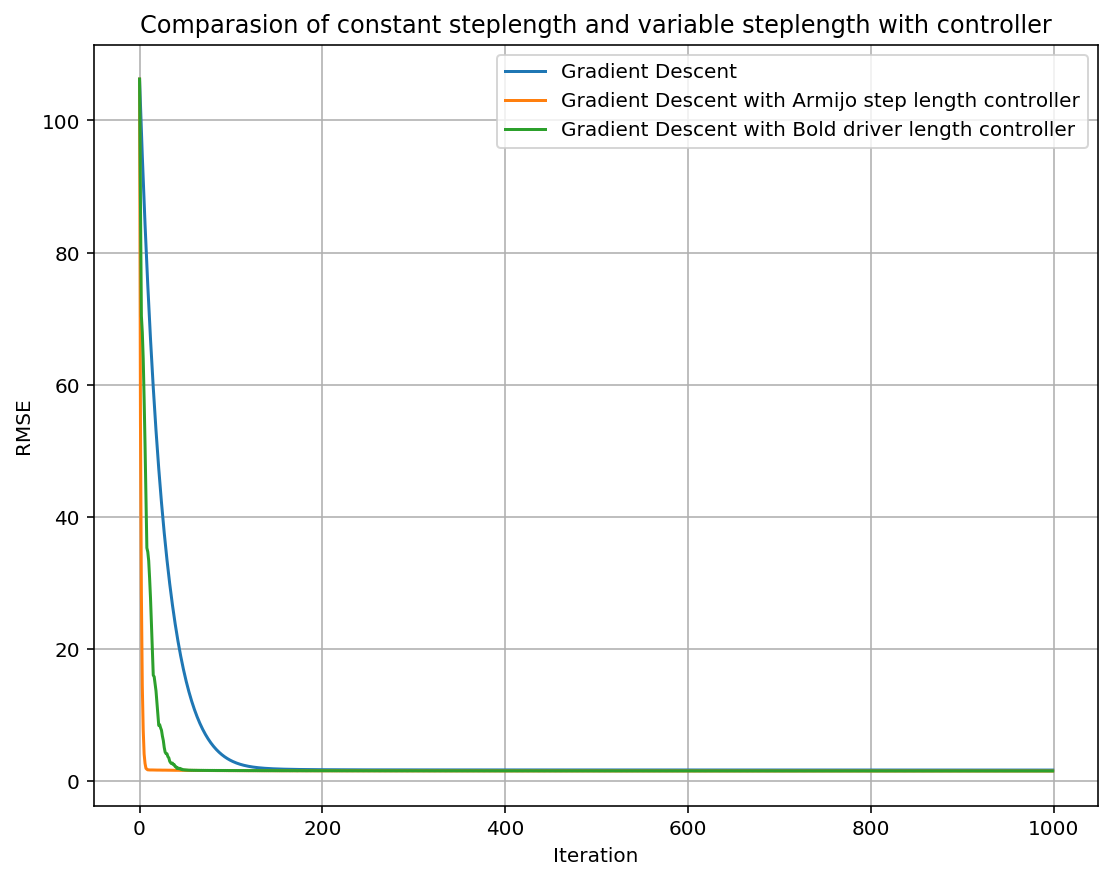

In [26]:
plt.close()
plt.figure(figsize=(9,7))
plt.plot(bestModelX, bestModelY, label = "Gradient Descent")
plt.plot(xArmijo, yRMSEArmijo, label = "Gradient Descent with Armijo step length controller")
plt.plot(xBold, yRMSEBold, label = "Gradient Descent with Bold driver length controller")

plt.grid()
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Comparasion of constant steplength and variable steplength with controller")
plt.legend()
plt.show()

# Gradient descent for wine data

## Load data
I am combining both red wine and white wine data in a single dataframe

In [27]:
"""Load redwine data and add a new feature type
type = 0 => RedWine
type = 1 => WhiteWine """

tmpFrame = pd.read_csv(directoryPath+"/winequality-red.csv", sep=";")
tmpFrame['type'] = 0
wineData = tmpFrame


tmpFrame = pd.read_csv(directoryPath+"/winequality-white.csv", sep=";")
tmpFrame['type'] = 1
wineData = pd.concat([wineData, tmpFrame])
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


## All data is numeric. Checking for NA data

In [28]:
wineData.dropna(inplace = True)
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


### Check for corelation between different X and Y
#### For red wine

In [29]:
redWine = wineData.loc[wineData['type'] == 0]
for column in redWine:
    if column != "quality":
        print("The corelation between " + column +" vs quality is " + 
              str(generatePearsonCoefficient(redWine[column], redWine['quality'])))

The corelation between fixed acidity vs quality is 0.124051649113
The corelation between volatile acidity vs quality is -0.390557780264
The corelation between citric acid vs quality is 0.226372514318
The corelation between residual sugar vs quality is 0.0137316373401
The corelation between chlorides vs quality is -0.12890655993
The corelation between free sulfur dioxide vs quality is -0.0506560572443
The corelation between total sulfur dioxide vs quality is -0.185100288927
The corelation between density vs quality is -0.174919227783
The corelation between pH vs quality is -0.0577313912054
The corelation between sulphates vs quality is 0.251397079069
The corelation between alcohol vs quality is 0.476166324001
The corelation between type vs quality is nan


#### For white wine

In [30]:
whiteWine = wineData.loc[wineData['type'] == 1]
for column in whiteWine:
    if column != "quality":
        print("The corelation between " + column +" vs quality is " + 
              str(generatePearsonCoefficient(whiteWine[column], whiteWine['quality'])))

The corelation between fixed acidity vs quality is -0.113662830713
The corelation between volatile acidity vs quality is -0.194722968921
The corelation between citric acid vs quality is -0.00920909088398
The corelation between residual sugar vs quality is -0.0975768288947
The corelation between chlorides vs quality is -0.209934410947
The corelation between free sulfur dioxide vs quality is 0.00815806712344
The corelation between total sulfur dioxide vs quality is -0.174737217597
The corelation between density vs quality is -0.307123312735
The corelation between pH vs quality is 0.0994272457367
The corelation between sulphates vs quality is 0.0536778771328
The corelation between alcohol vs quality is 0.435574715461
The corelation between type vs quality is nan


#### Combined

In [31]:
for column in wineData:
    if column != "quality":
        print("The corelation between " + column +" vs quality is " + 
              str(generatePearsonCoefficient(wineData[column], wineData['quality'])))

The corelation between fixed acidity vs quality is -0.0767432079096
The corelation between volatile acidity vs quality is -0.265699477611
The corelation between citric acid vs quality is 0.0855317171837
The corelation between residual sugar vs quality is -0.0369804845858
The corelation between chlorides vs quality is -0.200665500435
The corelation between free sulfur dioxide vs quality is 0.0554630586166
The corelation between total sulfur dioxide vs quality is -0.0413854538556
The corelation between density vs quality is -0.305857906069
The corelation between pH vs quality is 0.0195057037144
The corelation between sulphates vs quality is 0.0384854458765
The corelation between alcohol vs quality is 0.444318520008
The corelation between type vs quality is 0.119323284636


### Visualizing the data

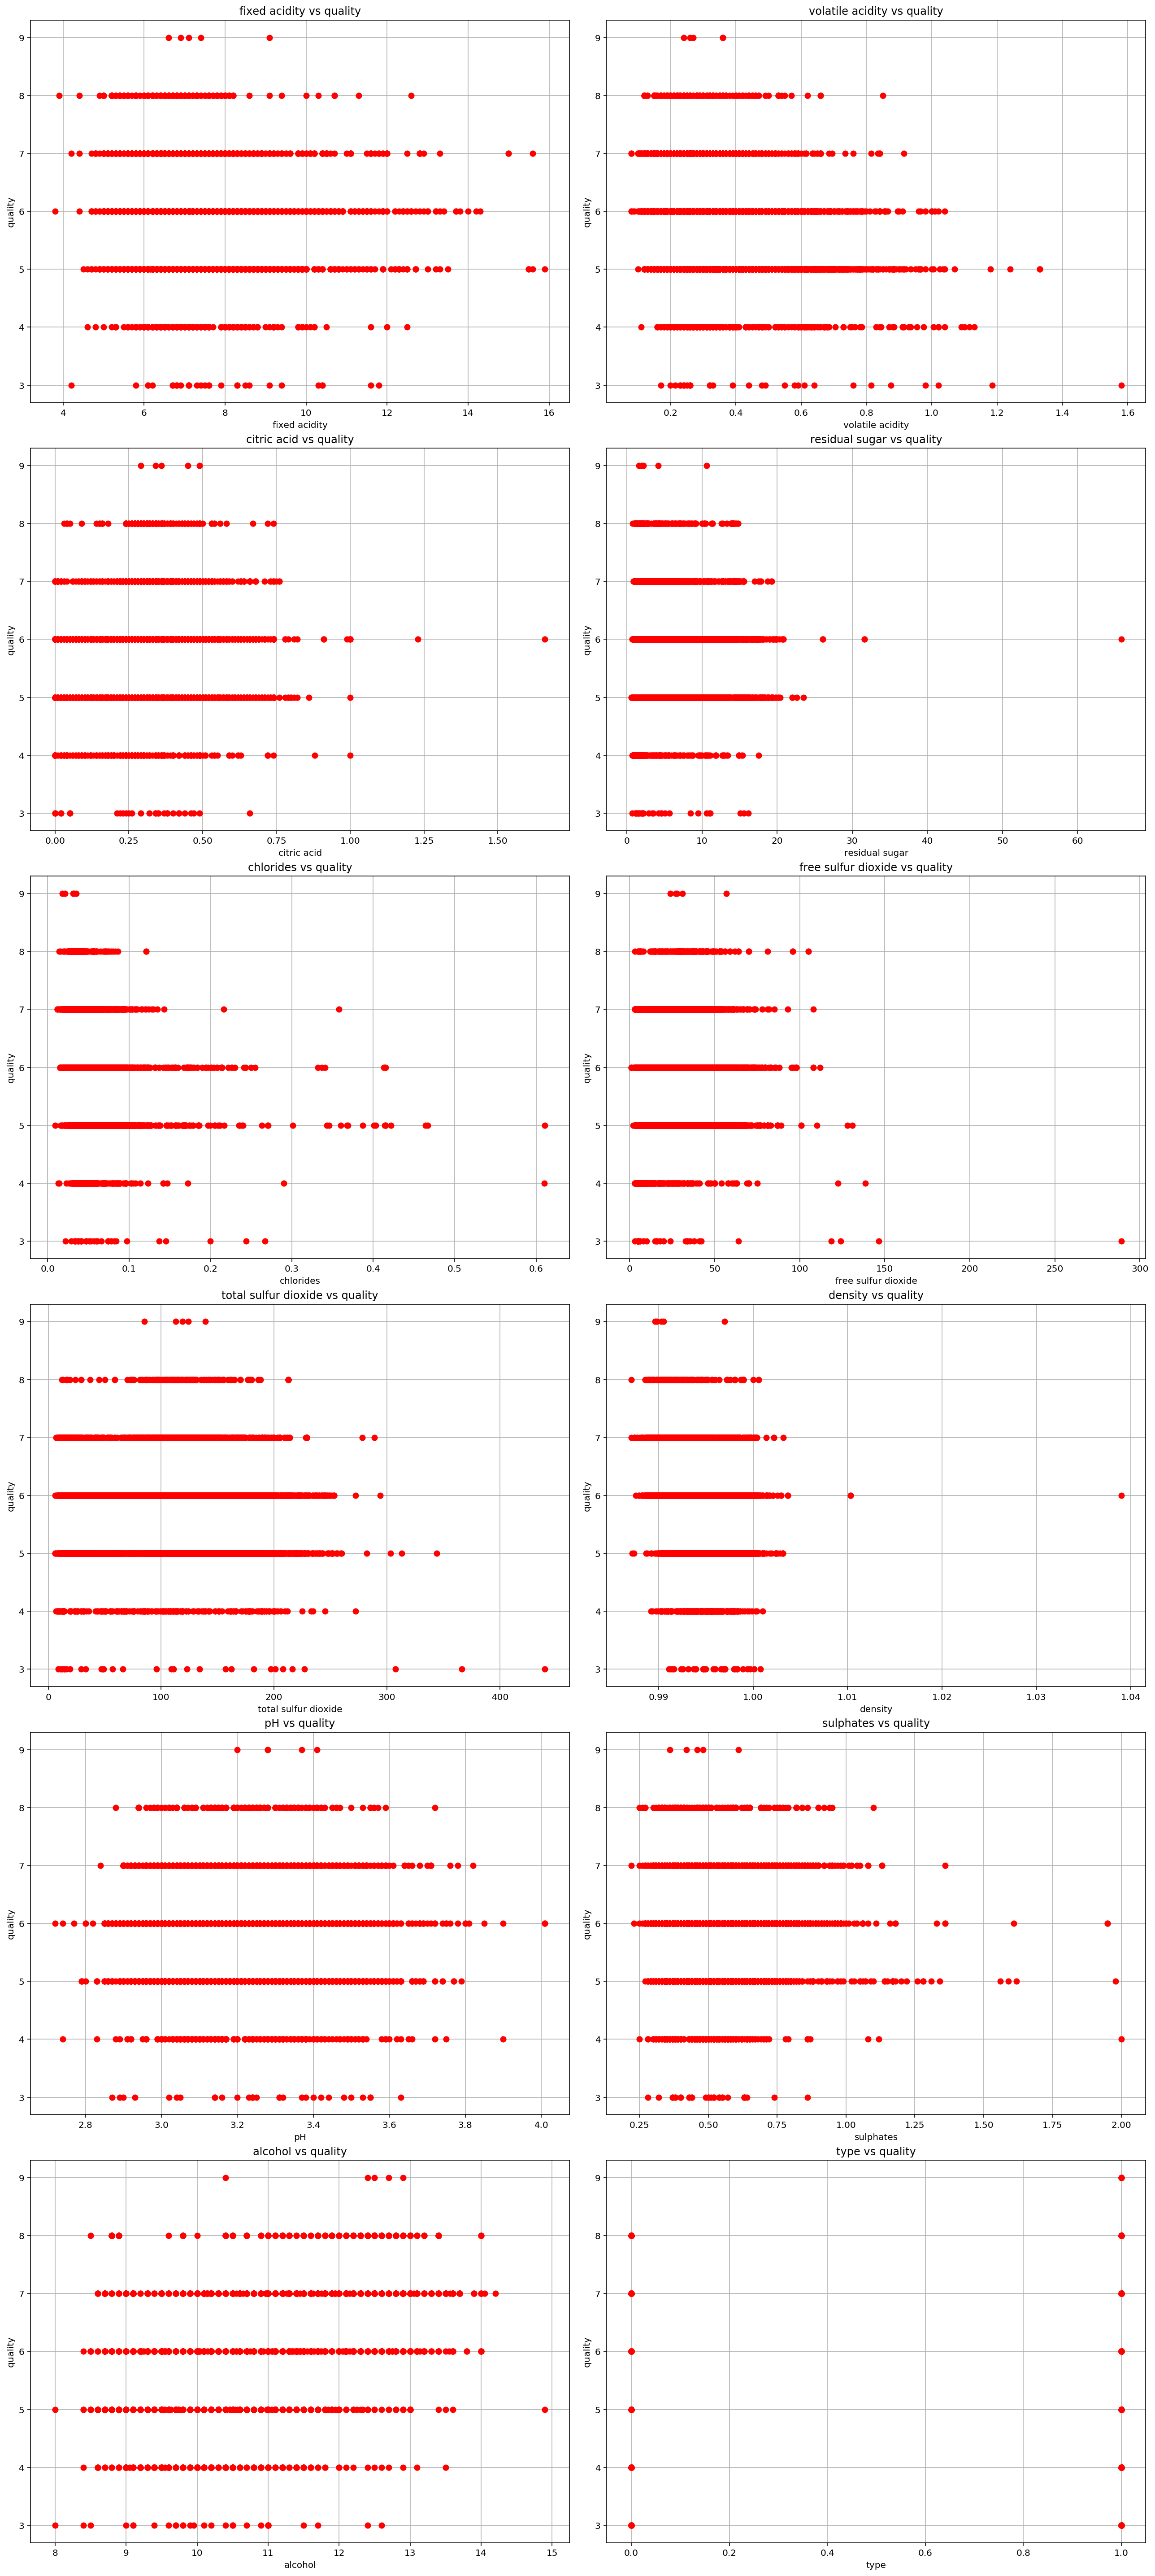

In [32]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12))  = plt.subplots(6,2,
                                                                                                    sharey='none')
figure.tight_layout()
figure.set_figheight(40)
ax1.plot(wineData['fixed acidity'], wineData.quality, "ro")
ax1.grid()
ax1.set_title("fixed acidity vs quality")
ax1.set_xlabel("fixed acidity")
ax1.set_ylabel("quality")

ax2.plot(wineData['volatile acidity'], wineData.quality, "ro")
ax2.grid()
ax2.set_title("volatile acidity vs quality")
ax2.set_xlabel("volatile acidity")
ax2.set_ylabel("quality")

ax3.plot(wineData['citric acid'], wineData.quality, "ro")
ax3.grid()
ax3.set_title("citric acid vs quality")
ax3.set_xlabel("citric acid")
ax3.set_ylabel("quality")

ax4.plot(wineData['residual sugar'], wineData.quality, "ro")
ax4.grid()
ax4.set_title("residual sugar vs quality")
ax4.set_xlabel("residual sugar")
ax4.set_ylabel("quality")

ax5.plot(wineData['chlorides'], wineData.quality, "ro")
ax5.grid()
ax5.set_title("chlorides vs quality")
ax5.set_xlabel("chlorides")
ax5.set_ylabel("quality")

ax6.plot(wineData['free sulfur dioxide'], wineData.quality, "ro")
ax6.grid()
ax6.set_title("free sulfur dioxide vs quality")
ax6.set_xlabel("free sulfur dioxide")
ax6.set_ylabel("quality")

ax7.plot(wineData['total sulfur dioxide'], wineData.quality, "ro")
ax7.grid()
ax7.set_title("total sulfur dioxide vs quality")
ax7.set_xlabel("total sulfur dioxide")
ax7.set_ylabel("quality")

ax8.plot(wineData['density'], wineData.quality, "ro")
ax8.grid()
ax8.set_title("density vs quality")
ax8.set_xlabel("density")
ax8.set_ylabel("quality")

ax9.plot(wineData['pH'], wineData.quality, "ro")
ax9.grid()
ax9.set_title("pH vs quality")
ax9.set_xlabel("pH")
ax9.set_ylabel("quality")

ax10.plot(wineData['sulphates'], wineData.quality, "ro")
ax10.grid()
ax10.set_title("sulphates vs quality")
ax10.set_xlabel("sulphates")
ax10.set_ylabel("quality")

ax11.plot(wineData['alcohol'], wineData.quality, "ro")
ax11.grid()
ax11.set_title("alcohol vs quality")
ax11.set_xlabel("alcohol")
ax11.set_ylabel("quality")

ax12.plot(wineData['type'], wineData.quality, "ro")
ax12.grid()
ax12.set_title("type vs quality")
ax12.set_xlabel("type")
ax12.set_ylabel("quality")


plt.show()


Selected features are volatile acidity, chlorides, density, alcohol and type

### Split data into trainSet and testSet

In [33]:
trainSet, testSet = splitDataSet(wineData, 0.8)

print(trainSet.shape)
print(testSet.shape)

(5198, 13)
(784, 13)


### Gradient descent no step length controller

Warning algorithm failed to converge in 1000 interations
RMSE nan
Warning algorithm failed to converge in 1000 interations
RMSE nan
Warning algorithm failed to converge in 1000 interations
RMSE 0.0276848704393


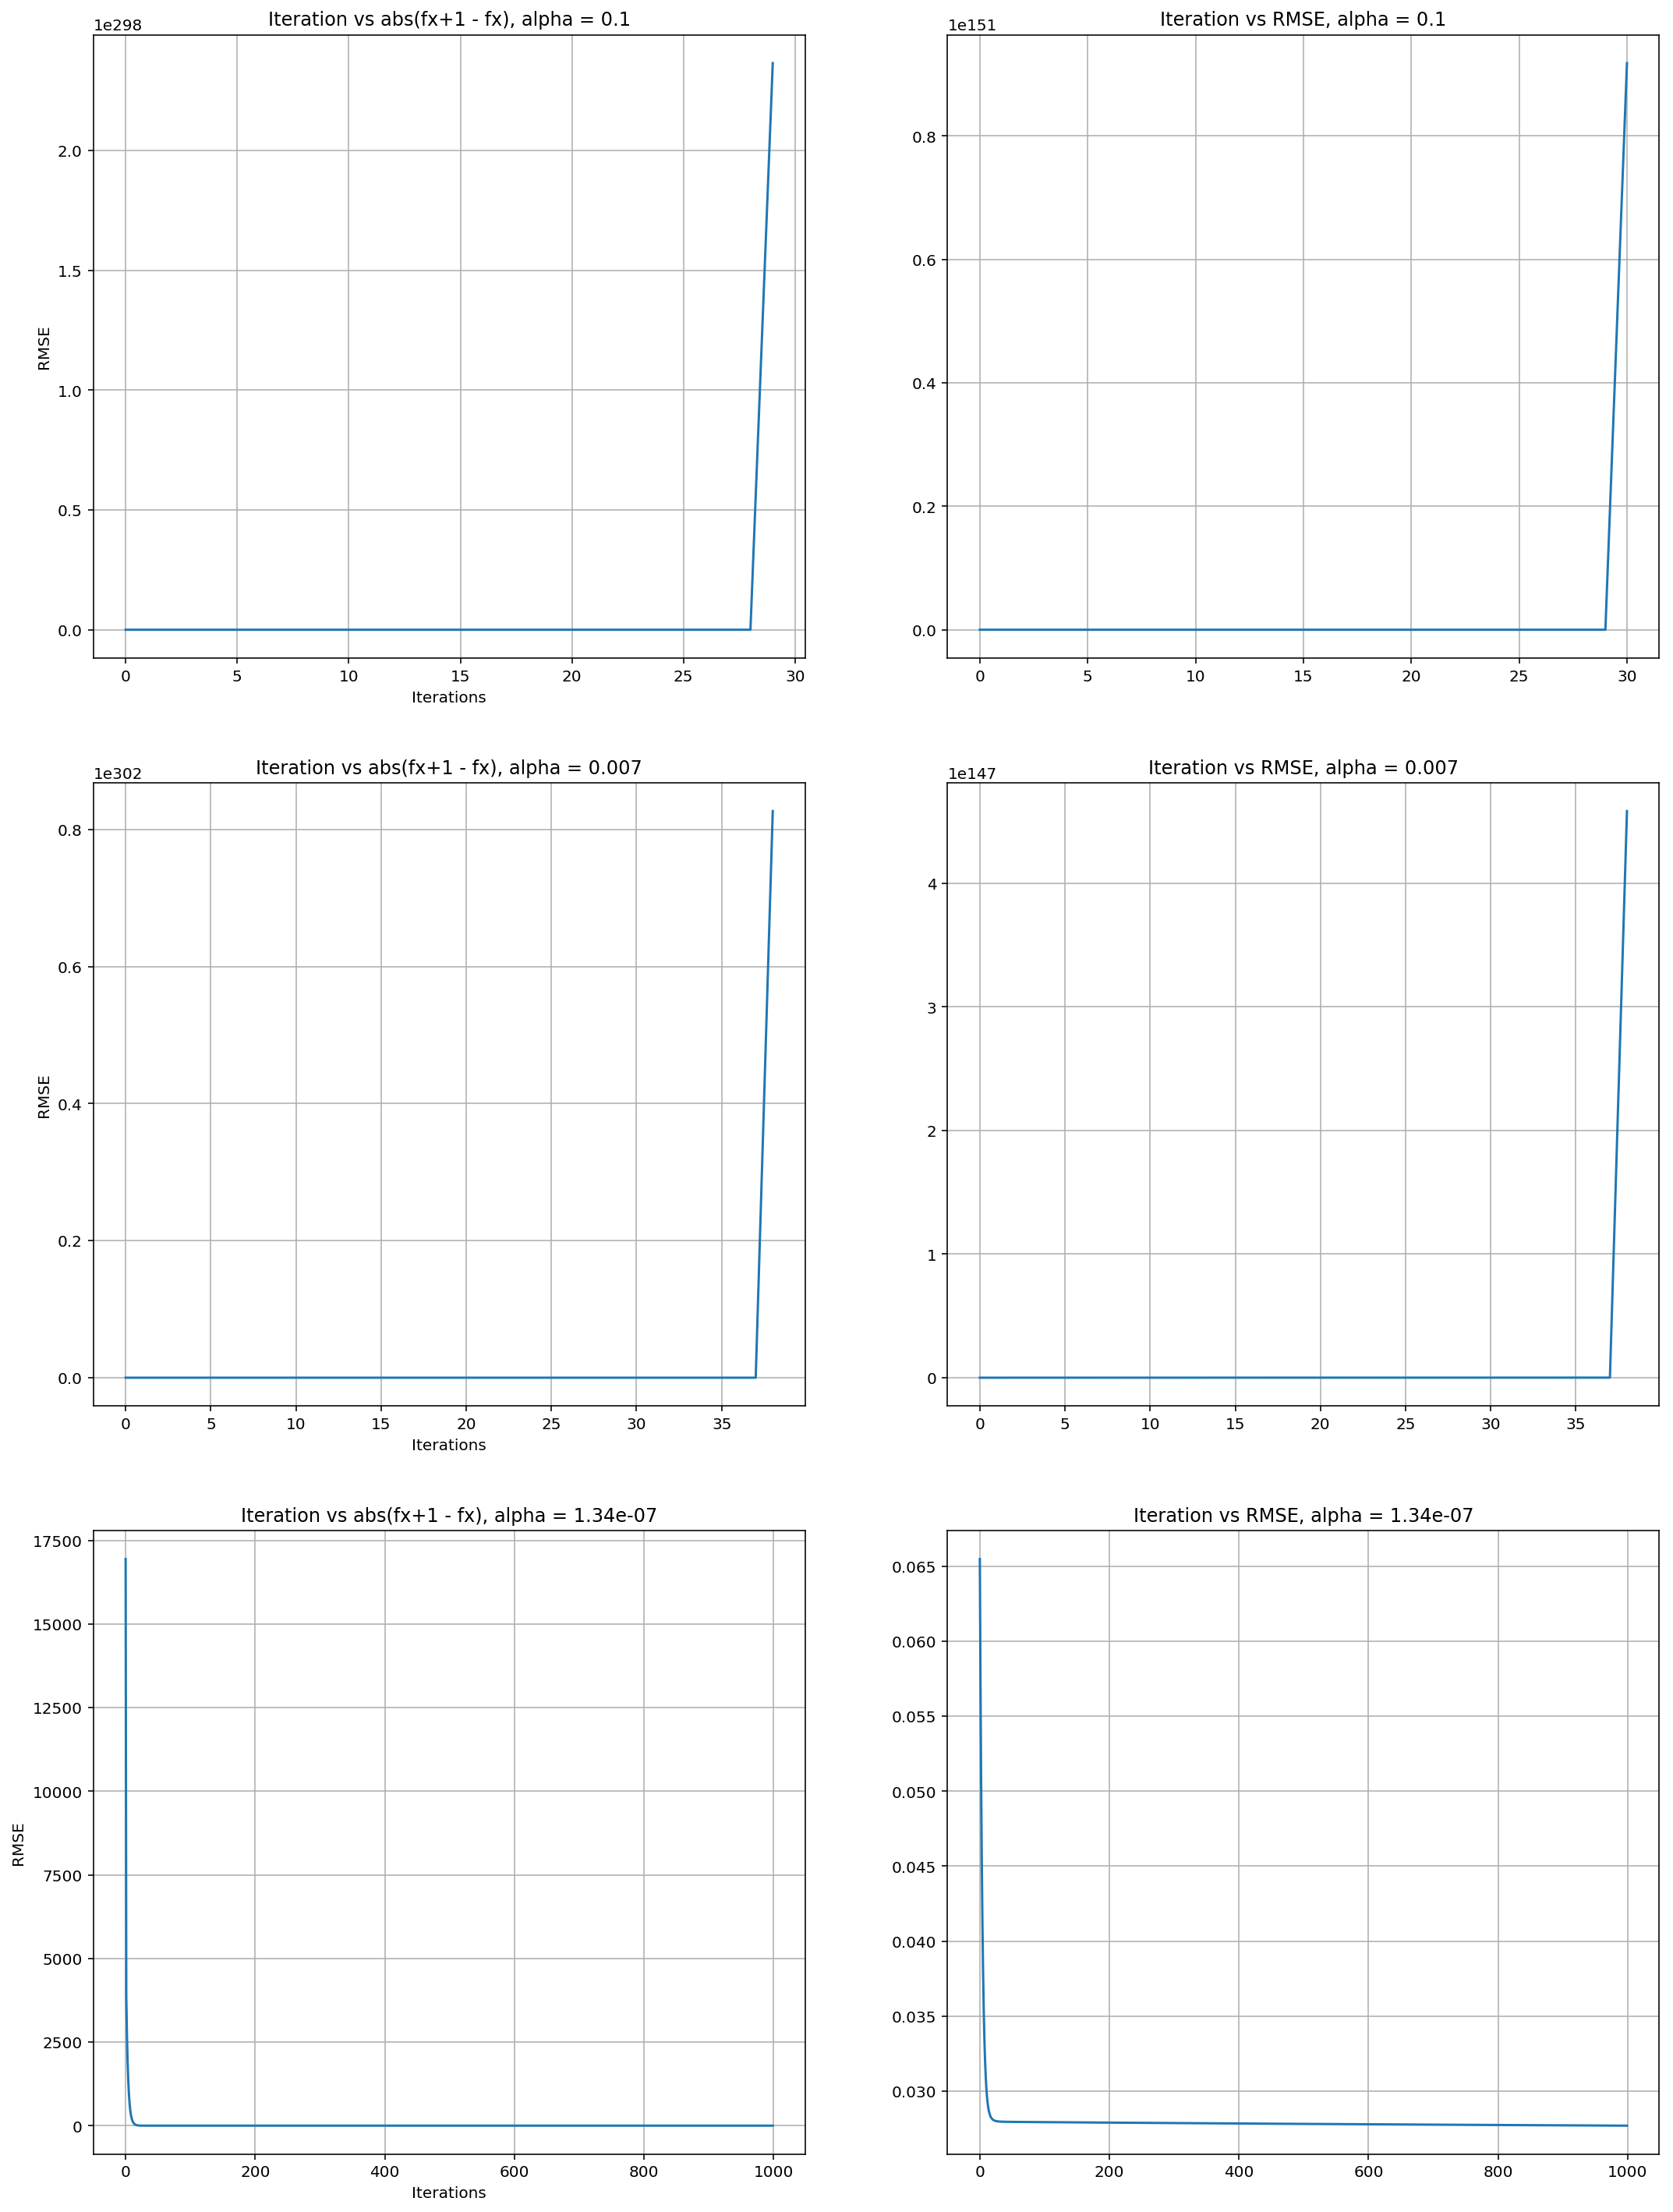

In [34]:
np.random.seed(8)
inputBeta = np.random.random_sample(6)

alpha_parameterGrid = [0.1, 0.007, 1.34e-7]

X_train = trainSet.as_matrix(columns = ['volatile acidity', 'chlorides', 'density', 'alcohol','type'])
X_test = testSet.as_matrix(columns = ['volatile acidity', 'chlorides', 'density', 'alcohol','type'])
Y_train = trainSet['quality']
Y_test = testSet['quality']

figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,sharey='none')
axis = ((ax1, ax2), (ax3, ax4), (ax5, ax6))
index = 0

bestModelParameters = None
bestModelX = None
bestModelY = None
leastRMSE = None
leastRSS = None
for alpha in alpha_parameterGrid:
    modelParameters, X, Ydiff, Yrmse, rss, rmse = linearRegressionGradientDescent(X_train, Y_train, X_test, Y_test,
                                                                           alpha, inputBeta,
                                                                           maxIterations = 1000)
    
    if not(isnan(rmse)):
        if leastRMSE is None or leastRMSE > rmse:
            leastRMSE = rmse
            bestModelParameters = modelParameters
            leastRSS = rss
            bestModelX = X
            bestModelY = Yrmse
            
    print("RMSE "+ str(rmse))
    
    axis[index][0].plot(X, Ydiff)
    axis[index][0].grid()
    axis[index][0].set_title("Iteration vs abs(fx+1 - fx), alpha = " + str(alpha))
    axis[index][0].set_xlabel("Iterations")
    axis[index][0].set_ylabel("abs(fx+1 - fx)")
    
    axis[index][1].plot(X, Yrmse)
    axis[index][1].grid()
    axis[index][1].set_title("Iteration vs RMSE, alpha = " + str(alpha))
    axis[index][0].set_xlabel("Iterations")
    axis[index][0].set_ylabel("RMSE")
    
    index = index + 1
    
plt.show()
plt.close()

### Graph description
<ul><li><b>Alpha = 0.1</b>
<br>Here the alpha value is very big. Because of this instead of converging we are diverging away. Both abs(fx+1 - fx) and RMSE appear to be diverging.
</li><li><b>Alpha = 0.007</b><br>Here also the alpha value is too big. The observed effect is still the same</li><li><b>Alpha = 1.34e-7</b>Now alpha value is small enough for algorithm to converge. RMSE is also converging</li>

### Best model

In [35]:
print("Best rmse for alpha grid is "+ str(leastRMSE))
print("Best rss for alpha grid is "+ str(leastRSS))

Best rmse for alpha grid is 0.0276848704393
Best rss for alpha grid is 3606.01226954


### Sample Predictions

In [36]:
yPrediction = predictionLinearRegression(X_test,bestModelParameters)
df = pd.DataFrame({"Actual":Y_test, "Prediction":yPrediction})
df.head(25)

,Actual,Prediction
11,5,5.877975
13,5,5.489550
21,5,5.490330
53,5,5.367689
123,5,5.699142
163,5,5.555240
189,5,5.504036
200,7,5.629069
209,7,5.684859
228,6,5.816304


### Armijo Step Length Controller

Warning using stepLengthController alpha values will be rewritten
Warning algorithm failed to converge in 1000 interations
RMSE 0.0264132183247


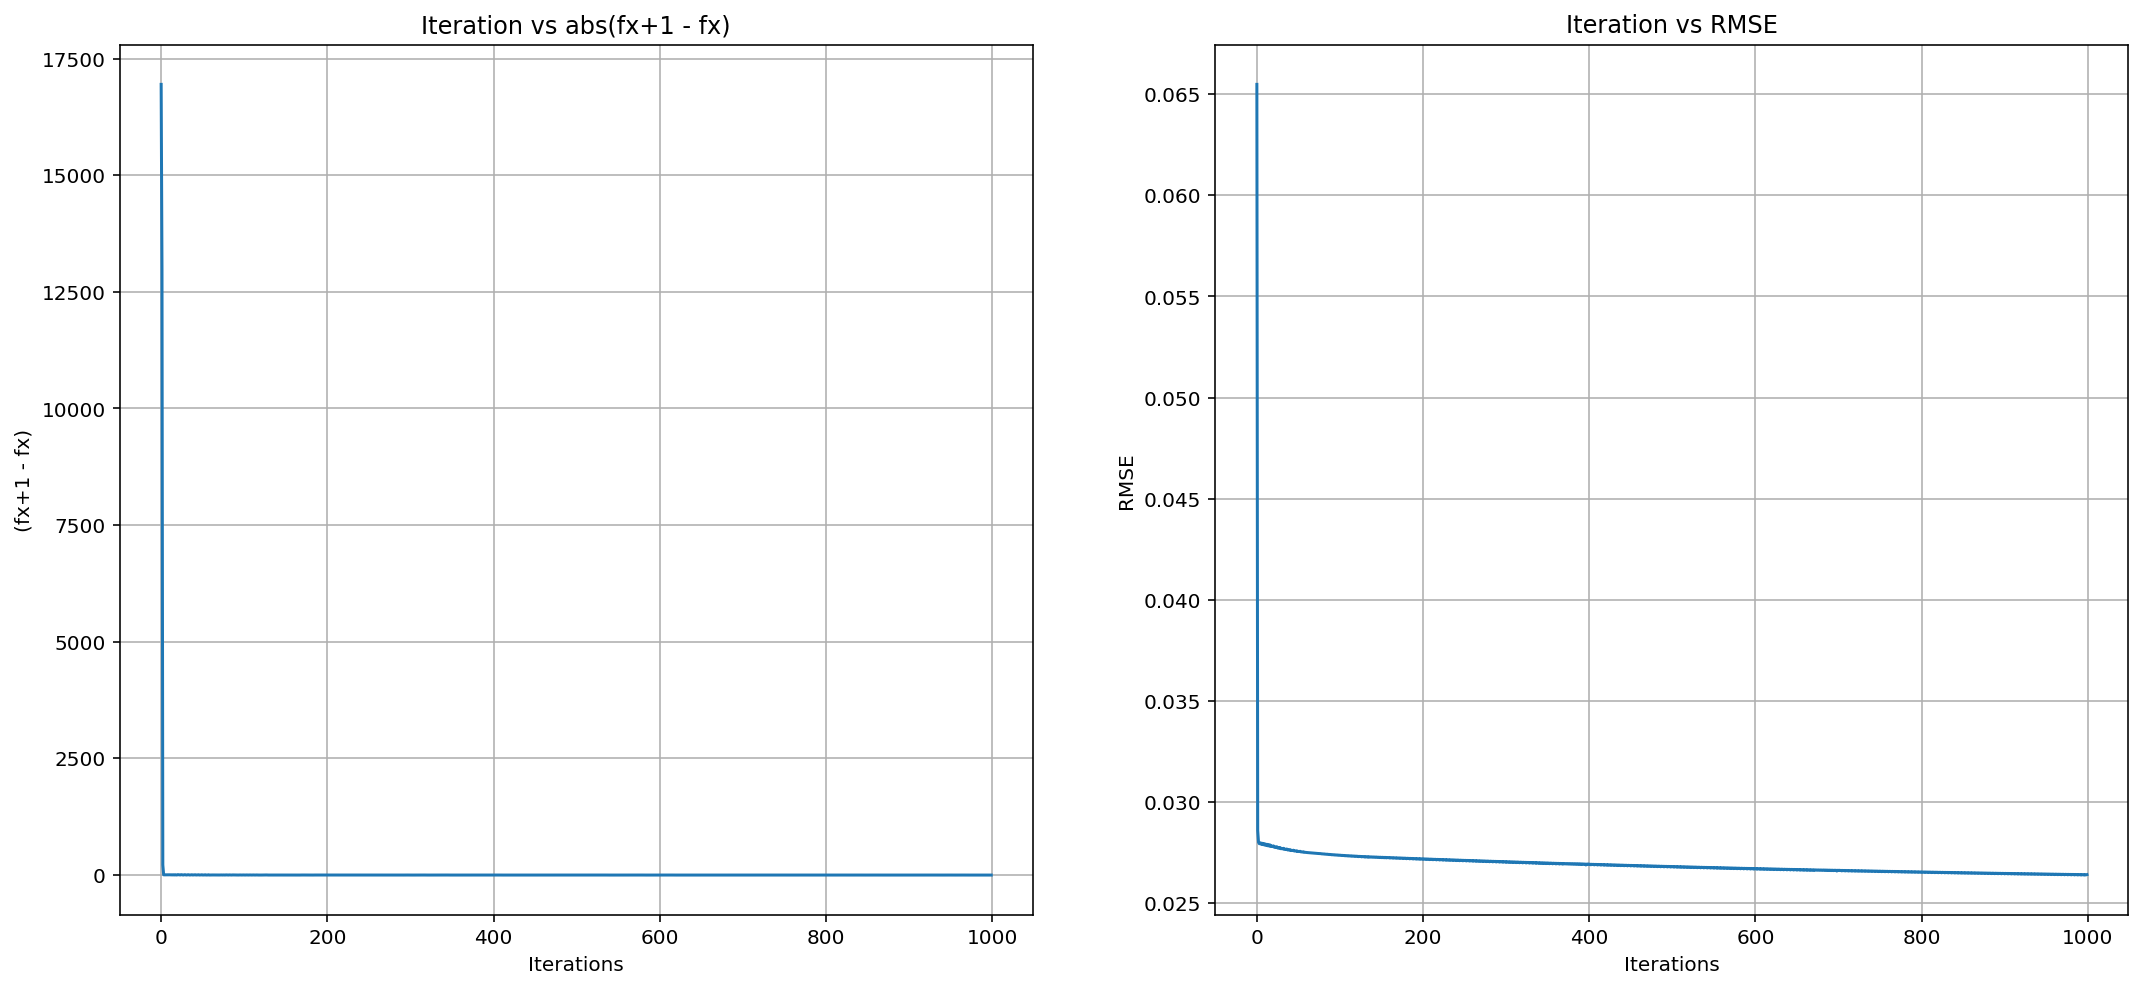

In [37]:
figure, ((ax1, ax2)) = plt.subplots(1, 2, sharey='none')

modelParameters, xArmijo, ydiffArmijo, yRMSEArmijo, rss, rmse = linearRegressionGradientDescent(X_train, Y_train,
                                                                 X_test, Y_test,
                                                                 alpha, inputBeta,
                                                                 maxIterations = 1000,
                                                                 stepLengthController = armijoStepLengthController,
                                                                 stepLengthControllerParameters = {"delta" : 0.2})
figure.set_figheight(8)
print("RMSE "+ str(rmse))
ax1.plot(xArmijo, ydiffArmijo)
ax1.grid()
ax1.set_title("Iteration vs abs(fx+1 - fx)")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("(fx+1 - fx)")
    
ax2.plot(xArmijo, yRMSEArmijo)
ax2.grid()
ax2.set_title("Iteration vs RMSE")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("RMSE")
plt.show()

### Sample predictions

In [38]:
yPrediction = predictionLinearRegression(X_test,modelParameters)
df = pd.DataFrame({"Actual":Y_test, "Prediction":yPrediction})
df.head(25)

,Actual,Prediction
11,5,5.629759
13,5,5.101835
21,5,5.392640
53,5,5.284907
123,5,5.178013
163,5,5.181374
189,5,5.274553
200,7,5.621535
209,7,5.702973
228,6,5.660471


### Bold Driver Step Length Controller

Warning using stepLengthController alpha values will be rewritten
Warning algorithm failed to converge in 1000 interations
RMSE 0.0270316264755


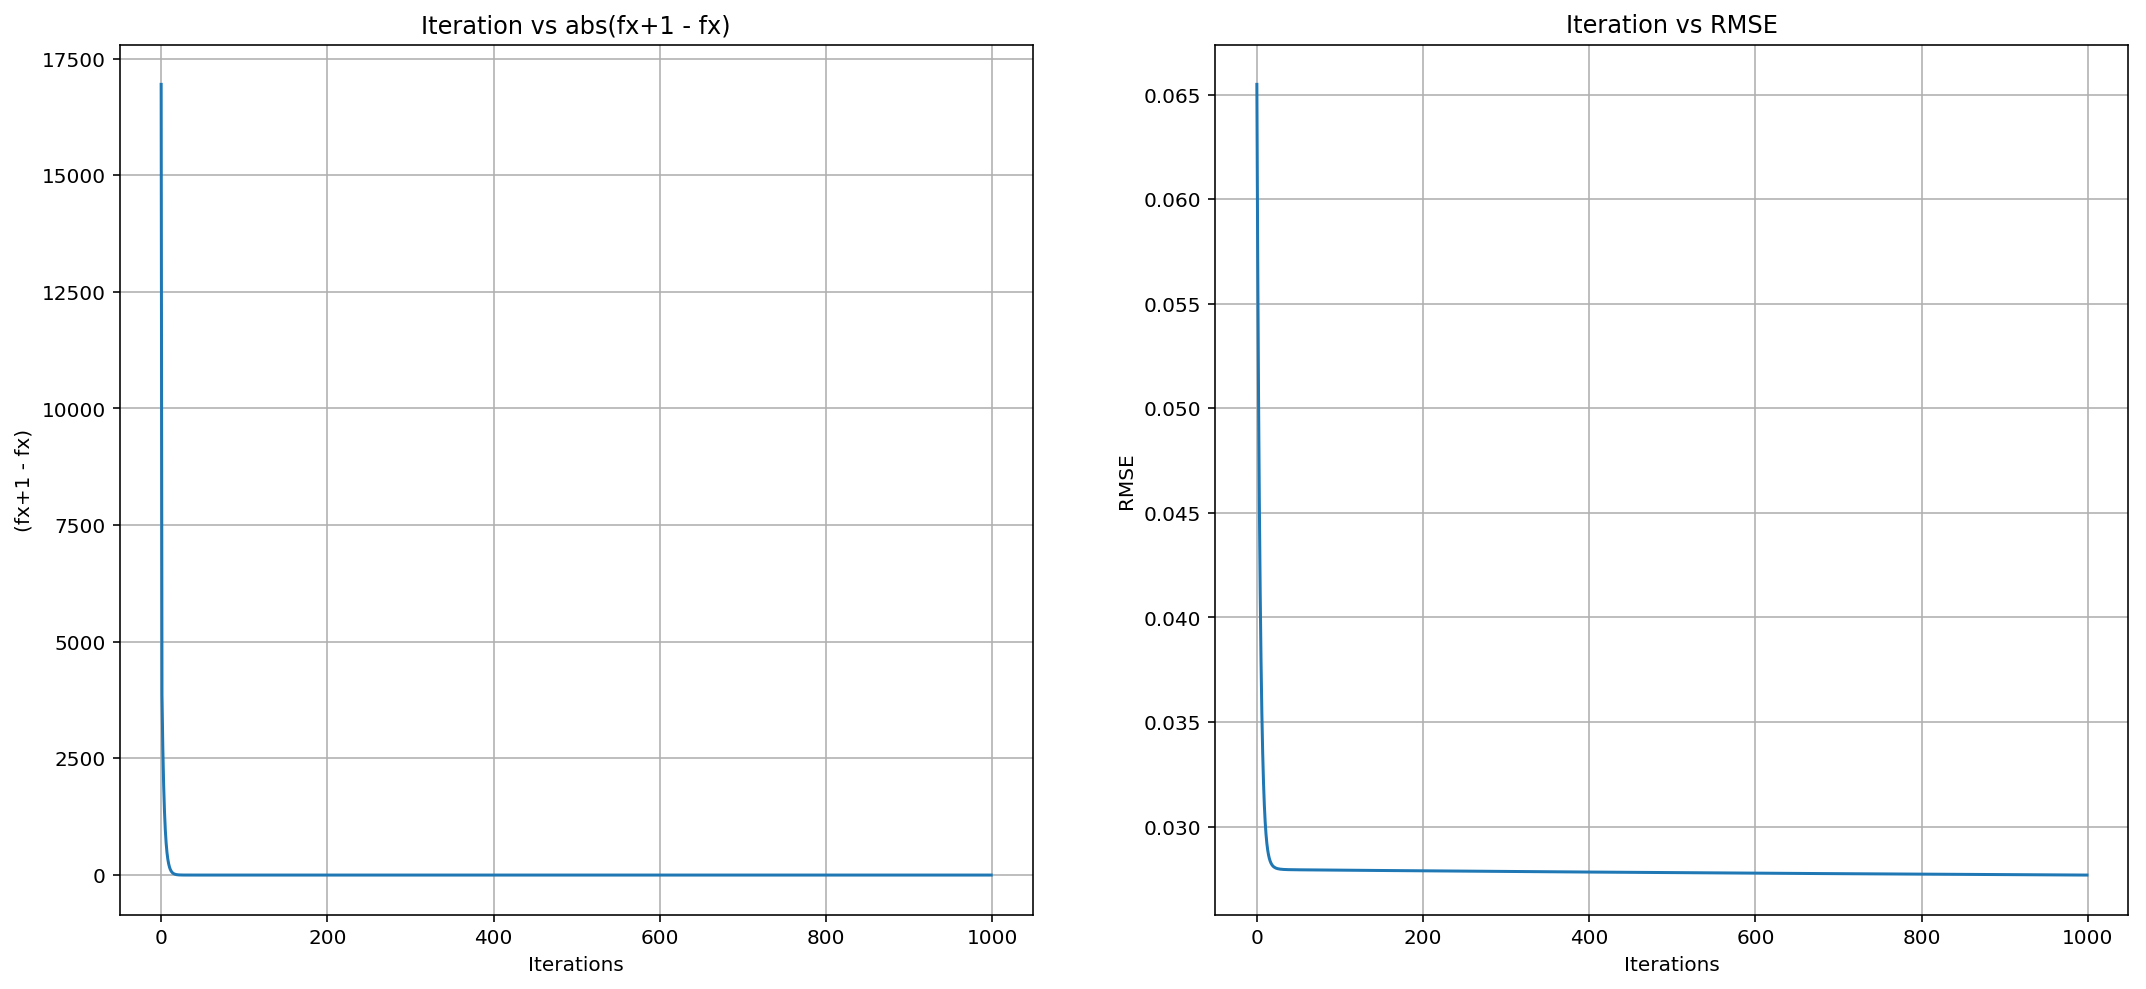

In [39]:
figure, ((ax1, ax2)) = plt.subplots(1, 2, sharey='none')

modelParameters, xBold, yDiffBold, yRMSEBold, rss, rmse = linearRegressionGradientDescent(X_train, Y_train, 
                                                        X_test, Y_test,
                                                        1.0, inputBeta, maxIterations = 1000,
                                                        stepLengthController = boldDriverStepLengthController,
                                                        stepLengthControllerParameters = 
                                                        {"alphaMinus" : 0.9, "alphaPlus" : 1.5})
figure.set_figheight(8)
print("RMSE "+ str(rmse))
ax1.plot(X, Ydiff)
ax1.grid()
ax1.set_title("Iteration vs abs(fx+1 - fx)")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("(fx+1 - fx)")
    
ax2.plot(X, Yrmse)
ax2.grid()
ax2.set_title("Iteration vs RMSE")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("RMSE")

plt.show()

### Sample predictions

In [40]:
yPrediction = predictionLinearRegression(X_test,modelParameters)
df = pd.DataFrame({"Actual":Y_test, "Prediction":yPrediction})
df.head(25)

,Actual,Prediction
11,5,5.620116
13,5,5.178078
21,5,5.303890
53,5,5.189713
123,5,5.326334
163,5,5.248307
189,5,5.260466
200,7,5.479164
209,7,5.545082
228,6,5.599436


### Comparasion

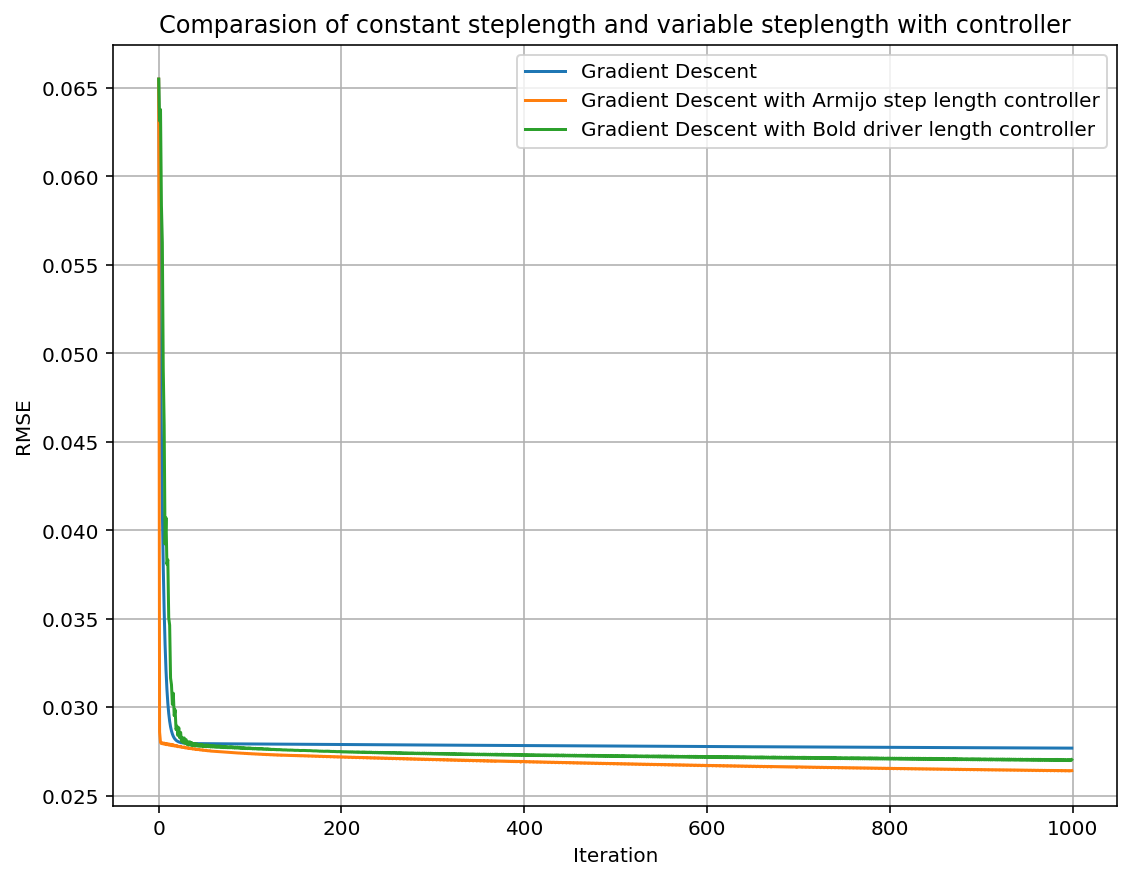

In [41]:
plt.close()
plt.figure(figsize=(9,7))
plt.plot(bestModelX, bestModelY, label = "Gradient Descent")
plt.plot(xArmijo, yRMSEArmijo, label = "Gradient Descent with Armijo step length controller")
plt.plot(xBold, yRMSEBold, label = "Gradient Descent with Bold driver length controller")

plt.grid()
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Comparasion of constant steplength and variable steplength with controller")
plt.legend()
plt.show()